<a href="https://colab.research.google.com/github/danieletirinnanzi/HUPLACLIP-NNs/blob/main/PlantedClique_NeuralNets_Daniele.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from google.colab import files

from __future__ import print_function
from __future__ import division
from torchvision import datasets, models, transforms
import time
import os
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


We define the function that generates the adjacency matrices with and without the cliques. The default probability to get a graph with a clique is  50 . The adjacency matrices in this case represents an Erdos-Renyi graph where the probability  p  to have an edge between two nodes is such that both the graph with and without the planted clique have the same average degree ( p=0.5  by default).

In [26]:
def plant_clique(graph, clique_size, graph_size):
    """
    Plants a clique of specified size within a given graph.

    Args:
        graph (torch.Tensor): Adjacency matrix representing the graph.
        size (int): Size of the clique to be planted.
        graph_size (int): Total number of nodes in the graph.

    Returns:
        torch.Tensor: Modified adjacency matrix with the planted clique.
    """
    graph[:clique_size, :clique_size] = 1
    random_permutation = torch.randperm(graph_size)
    graph = graph[random_permutation[:, None], random_permutation]
    return graph

def generate_graphs(number_of_graphs, graph_size, clique_size, p_nodes=0.5, p_clique=0.5):
    """
    Generates multiple graphs.

    Args:
        number_of_graphs (int): Number of graphs to generate.
        graph_size (int): Number of nodes in each graph.
        clique_size (int): Size of the planted clique.
        p_nodes (float): Probability of an edge being present between two nodes.
        p_clique (float): Probability of a graph having a planted clique.

    Returns:
        tuple: A tuple containing the generated data and the on_off flag for each graph.
    """
    on_off = torch.bernoulli(p_clique * torch.ones(number_of_graphs)).bool()
    data = torch.zeros(number_of_graphs, 1, graph_size, graph_size)
    for i in range(number_of_graphs):
      # generating lower triangle of the adjacency matrix
        if not on_off[i]:
          # clique not present
          p_corrected = p_nodes - (1 - p_nodes) * (clique_size * (clique_size - 1)) / (graph_size * (graph_size - 1))
          adjacency_matrix = torch.bernoulli(p_corrected * torch.ones(graph_size, graph_size))
        else:
          # clique present
          adjacency_matrix = torch.bernoulli(p_nodes * torch.ones(graph_size, graph_size))
          # adding clique to adjacency matrix
          adjacency_matrix = plant_clique(adjacency_matrix, clique_size, graph_size)
        # generating upper triangular matrix
        upper_triangular = torch.triu(adjacency_matrix)
        adjacency_matrix = upper_triangular + torch.transpose(upper_triangular, 0, 1)
        adjacency_matrix.fill_diagonal_(1)
        # adding graph to the matrix of graphs
        data[i, 0] = adjacency_matrix
    return data, on_off.tolist()

# Multilayer Perceptrons (MLPs)

Here we define the MLPs. The meaning of each parameter is explained below. This network works only with graphs of a certain size, a different graph needs a slightly different architecture. There is also an early stopping function, which stops if the validation error starts to increase for several steps.

The architecture is made by stacking many layers of neurons of different sizes. The optimizier is Adam and the loss is the CrossEntropy.

In [27]:
graph_size = 100        # graph dimension
lr_rate=0.01            # learning rate
l1=1000                 # number of neurons in the first layer
l2=500                  # number of neurons in the second layer
l3=100                  # number of neurons in the third layer
l4=20                   # number of neurons in the fourth layer
dropout_prob=0.2        # dropout probability

#function for the early stopping
def EarlyStopper(validation_loss, counter, min_validation_loss, past=0, patience=0, min_delta=0.01):
    """
    Implements early stopping based on validation loss.

    Args:
        validation_loss (numpy.array): Array containing validation loss values.
        counter (int): Current count of epochs where validation loss increases.
        min_validation_loss (float): Minimum validation loss encountered so far.
        past (int): Number of previous epochs to consider for calculating average validation loss.
        patience (int): Number of epochs to wait before triggering early stopping.
        min_delta (float): Minimum change in validation loss considered significant.

    Returns:
        tuple: A tuple containing a boolean indicating whether to stop early, the updated minimum validation loss,
               and the current counter.
    """
    length = validation_loss.shape[0]
    if np.mean(validation_loss[length - past:]) < min_validation_loss and length > past:
        # If average validation loss decreased, update min_validation_loss and reset counter
        min_validation_loss = np.mean(validation_loss[length - past:])
        counter = 0
    elif np.mean(validation_loss[length - past:]) > (min_validation_loss + min_delta) and length > past:
        # If average validation loss increased beyond min_delta, increment counter
        counter += 1
        if counter >= patience:
            # If counter exceeds patience, trigger early stopping
            return True, min_validation_loss, counter
    return False, min_validation_loss, counter

# building the architecture
model_d = nn.Sequential(
    nn.Flatten(),
    nn.Linear(graph_size*graph_size,l1),
    nn.BatchNorm1d(l1),
    nn.ReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(l1,l2),
    nn.BatchNorm1d(l2),
    nn.ReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(l2,l3),
    nn.BatchNorm1d(l3),
    nn.ReLU(),
    nn.Linear(l3,2),
    nn.BatchNorm1d(2),
    nn.ReLU(),
)

optim=torch.optim.Adam(model_d.parameters())   # optimization with Adam
criterion = nn.CrossEntropyLoss()            # criterion = Cross Entropy
model_d.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=10000, out_features=1000, bias=True)
  (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=1000, out_features=500, bias=True)
  (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=500, out_features=100, bias=True)
  (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=100, out_features=2, bias=True)
  (13): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
)

The following is the traing procedure. It works in the following way: at each epoch we generate a batch of training samples. Then we train the network with this batch and check the validation error. This online generation of batches ensures a faster training.

Eventually we also plot the generalization error versus the parameter $k/\sqrt{n}$.

If you want to run the code test with small number of epochs, small max_step or smaller samples; the code takes very long.

Percentage of training completed =  0.0 %. Epoch number:  1
epoch index =  0
dim_clique = 50
training error = 0.24450162053108215
validation error = 0.17516925930976868
test error = 0.17595729231834412
--------------------------------------------
Early stop
--------------------------------------------


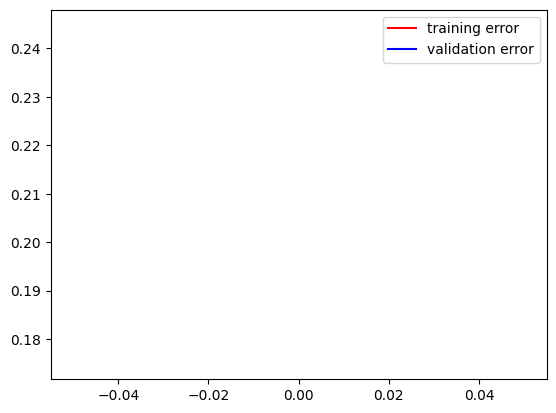

clique size:  50 $k/sqrt{n}$ = [5.0] % correct on test set = [100.0]
Percentage of training completed =  0.0 %. Epoch number:  1
epoch index =  0
dim_clique = 48
training error = 0.17083889245986938
validation error = 0.17136868834495544
test error = 0.18441173434257507
--------------------------------------------
Early stop
--------------------------------------------


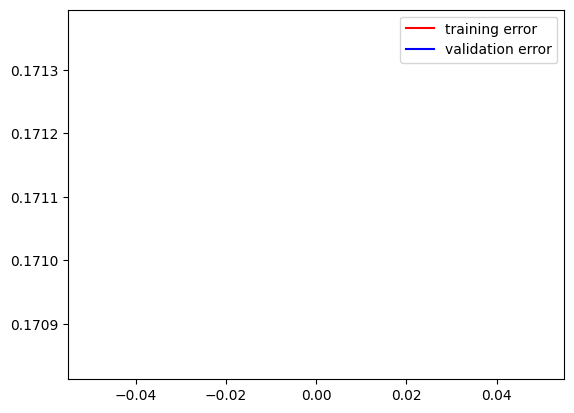

clique size:  48 $k/sqrt{n}$ = [5.0, 4.8] % correct on test set = [100.0, 100.0]
Percentage of training completed =  0.0 %. Epoch number:  1
epoch index =  0
dim_clique = 46
training error = 0.17599354684352875
validation error = 0.17603524029254913
test error = 0.18533483147621155
--------------------------------------------
Early stop
--------------------------------------------


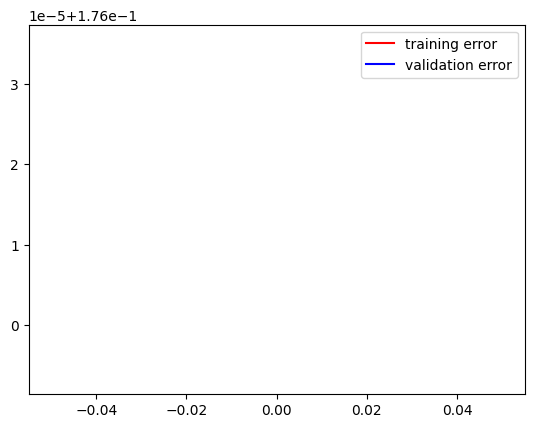

clique size:  46 $k/sqrt{n}$ = [5.0, 4.8, 4.6] % correct on test set = [100.0, 100.0, 100.0]
Percentage of training completed =  0.0 %. Epoch number:  1
epoch index =  0
dim_clique = 44
training error = 0.1841268390417099
validation error = 0.17089176177978516
test error = 0.170879527926445
--------------------------------------------
Early stop
--------------------------------------------


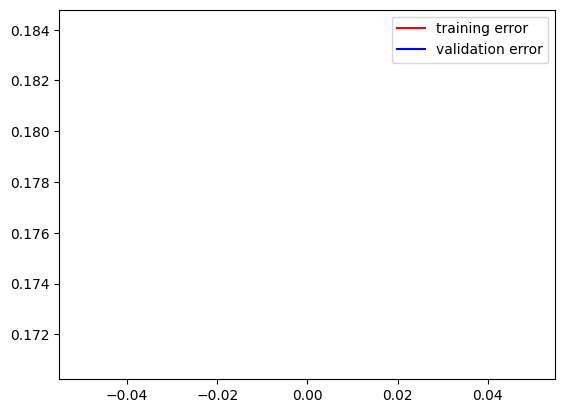

clique size:  44 $k/sqrt{n}$ = [5.0, 4.8, 4.6, 4.4] % correct on test set = [100.0, 100.0, 100.0, 100.0]
Percentage of training completed =  0.0 %. Epoch number:  1


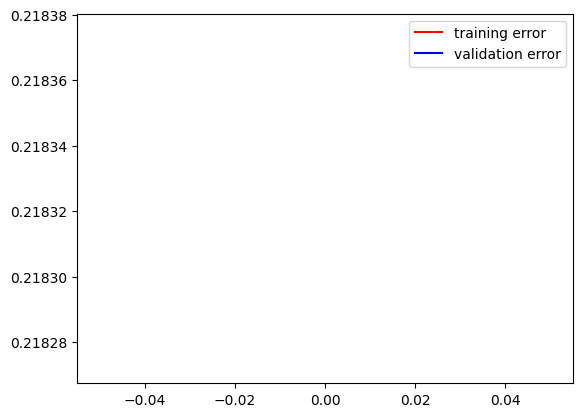

--------------------------------------------
Percentage of training completed =  16.666666666666668 %. Epoch number:  1


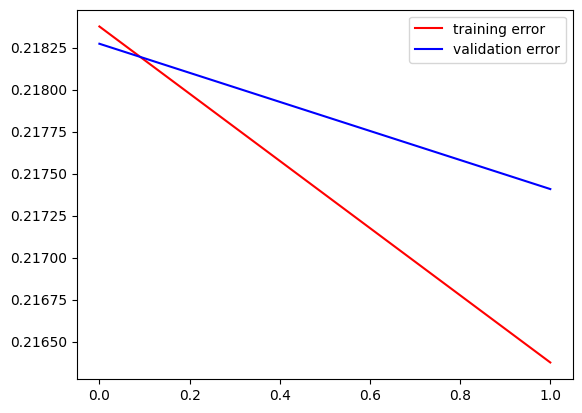

--------------------------------------------
Percentage of training completed =  33.333333333333336 %. Epoch number:  1


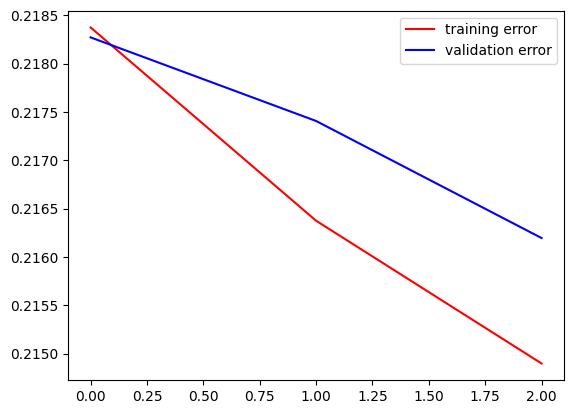

--------------------------------------------
Percentage of training completed =  50.0 %. Epoch number:  1


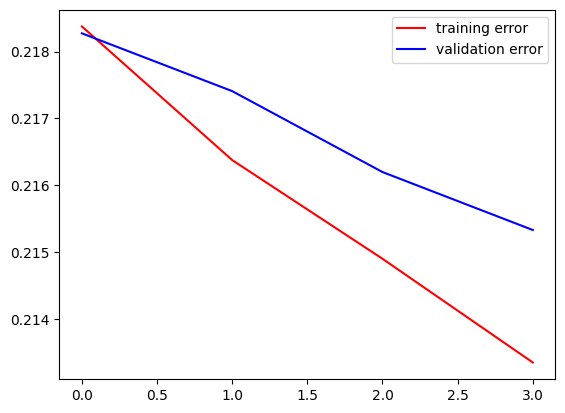

--------------------------------------------
Percentage of training completed =  66.66666666666667 %. Epoch number:  1


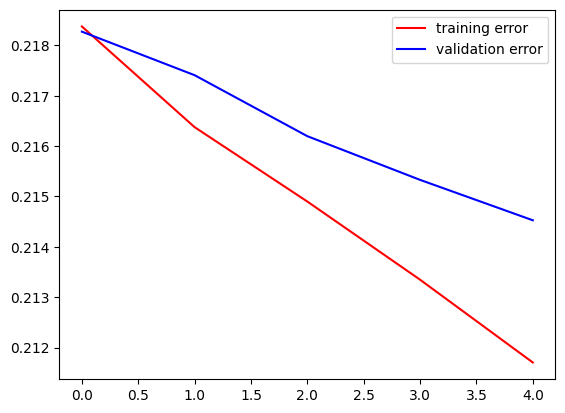

--------------------------------------------
Percentage of training completed =  83.33333333333333 %. Epoch number:  1


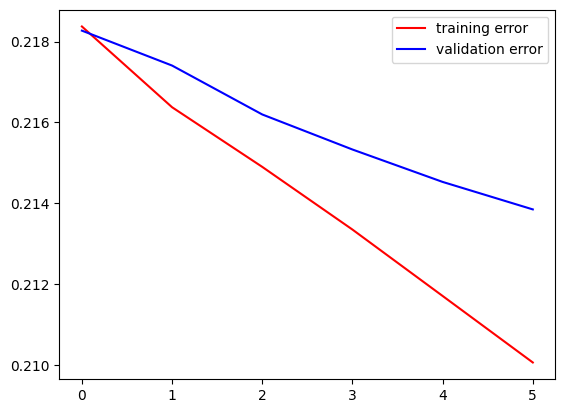

--------------------------------------------
epoch index =  0
dim_clique = 42
training error = 0.21005737781524658
validation error = 0.2138468325138092
test error = 0.19422726333141327
--------------------------------------------
Percentage of training completed =  0.0 %. Epoch number:  2
epoch index =  1
dim_clique = 42
training error = 0.17003796994686127
validation error = 0.1639273464679718
test error = 0.19486741721630096
--------------------------------------------
Early stop
--------------------------------------------


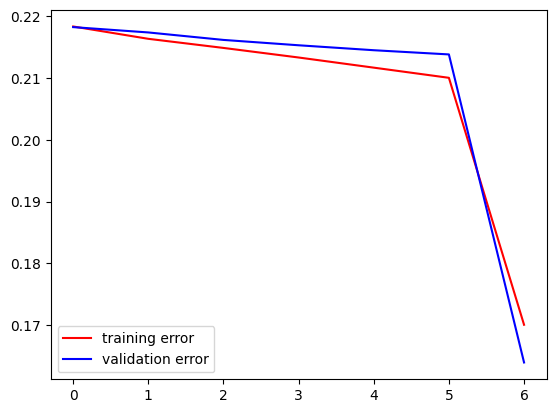

clique size:  42 $k/sqrt{n}$ = [5.0, 4.8, 4.6, 4.4, 4.2] % correct on test set = [100.0, 100.0, 100.0, 100.0, 100.0]
Percentage of training completed =  0.0 %. Epoch number:  1


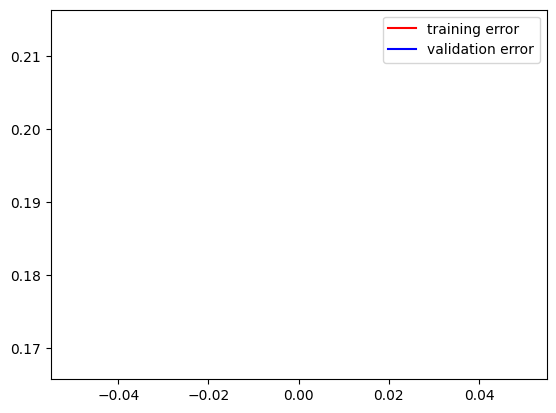

--------------------------------------------
Percentage of training completed =  16.666666666666668 %. Epoch number:  1


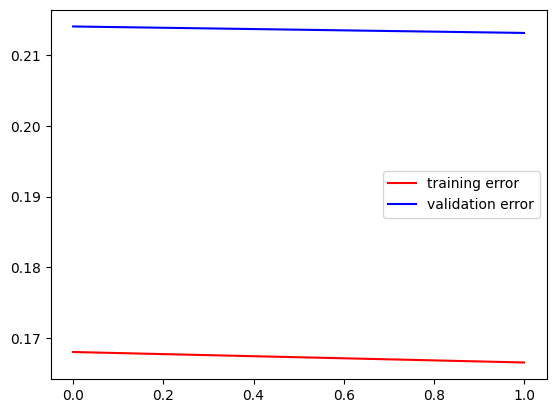

--------------------------------------------
Percentage of training completed =  33.333333333333336 %. Epoch number:  1


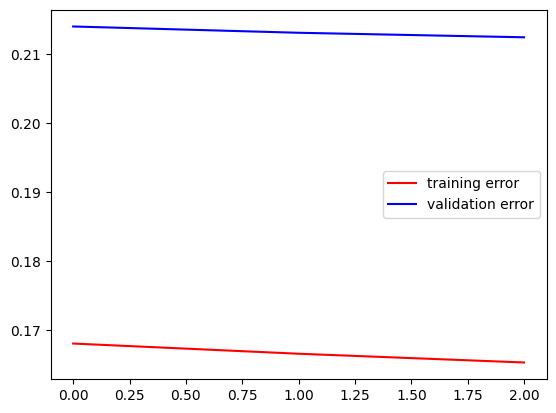

--------------------------------------------
Percentage of training completed =  50.0 %. Epoch number:  1


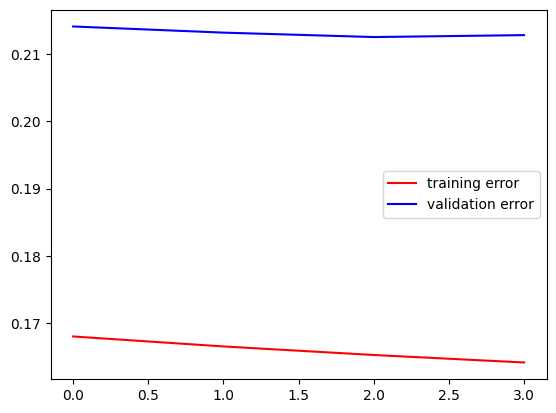

--------------------------------------------
Percentage of training completed =  66.66666666666667 %. Epoch number:  1


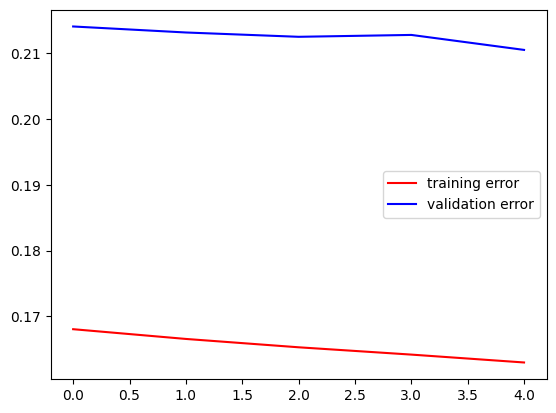

--------------------------------------------
Percentage of training completed =  83.33333333333333 %. Epoch number:  1


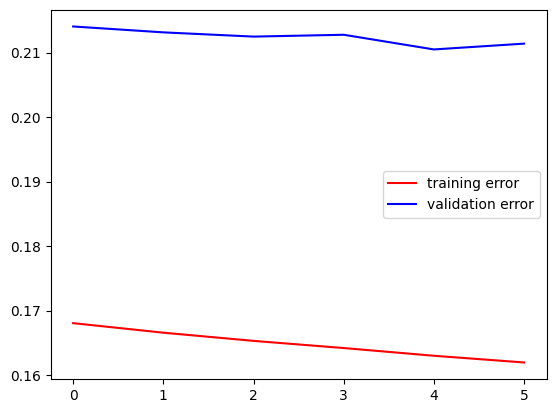

--------------------------------------------
epoch index =  0
dim_clique = 40
training error = 0.16194432973861694
validation error = 0.21138469874858856
test error = 0.15791015326976776
--------------------------------------------
Percentage of training completed =  0.0 %. Epoch number:  2
epoch index =  1
dim_clique = 40
training error = 0.15855099260807037
validation error = 0.15866035223007202
test error = 0.15767702460289001
--------------------------------------------
Early stop
--------------------------------------------


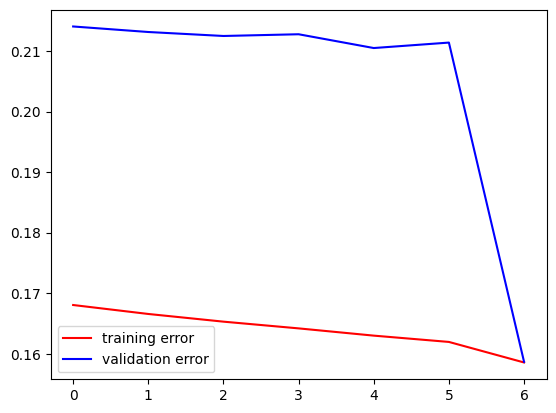

clique size:  40 $k/sqrt{n}$ = [5.0, 4.8, 4.6, 4.4, 4.2, 4.0] % correct on test set = [100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Percentage of training completed =  0.0 %. Epoch number:  1


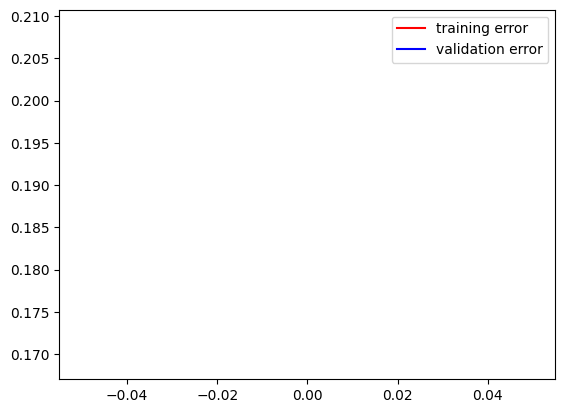

--------------------------------------------
Percentage of training completed =  16.666666666666668 %. Epoch number:  1


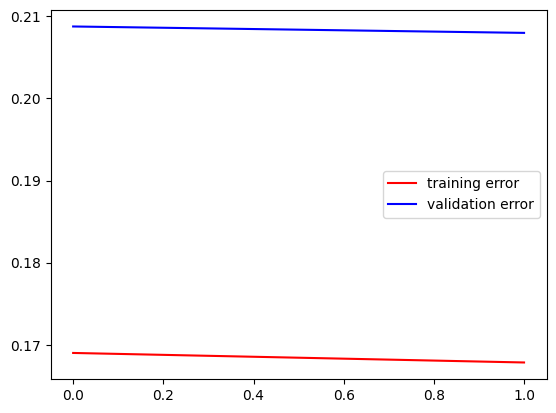

--------------------------------------------
Percentage of training completed =  33.333333333333336 %. Epoch number:  1


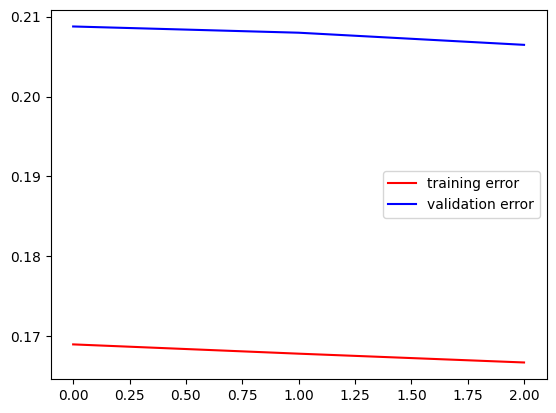

--------------------------------------------
Percentage of training completed =  50.0 %. Epoch number:  1


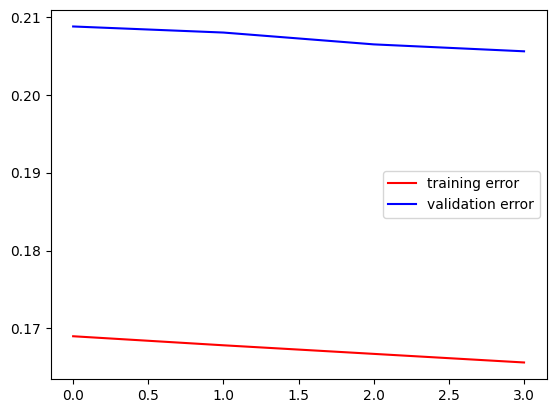

--------------------------------------------
Percentage of training completed =  66.66666666666667 %. Epoch number:  1


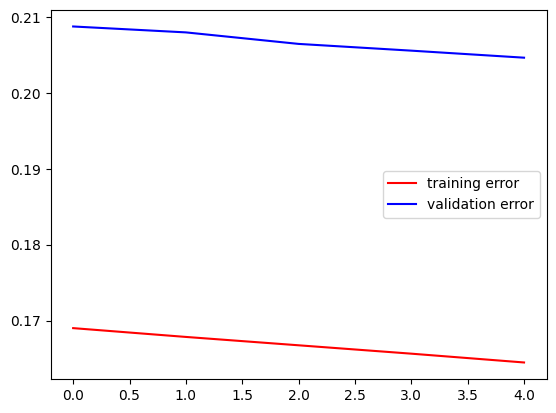

--------------------------------------------
Percentage of training completed =  83.33333333333333 %. Epoch number:  1


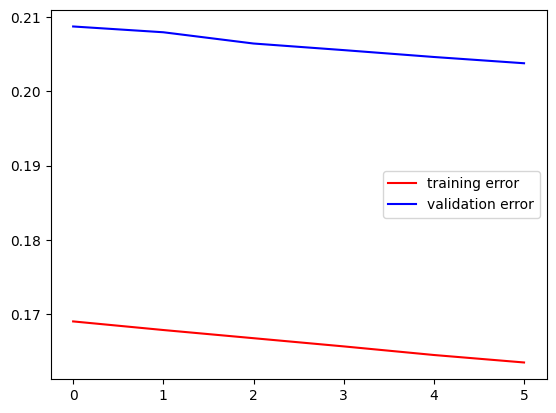

--------------------------------------------
epoch index =  0
dim_clique = 38
training error = 0.1634635031223297
validation error = 0.20380374789237976
test error = 0.15261967480182648
--------------------------------------------
Percentage of training completed =  0.0 %. Epoch number:  2
epoch index =  1
dim_clique = 38
training error = 0.15878772735595703
validation error = 0.1685626208782196
test error = 0.15277524292469025
--------------------------------------------
Early stop
--------------------------------------------


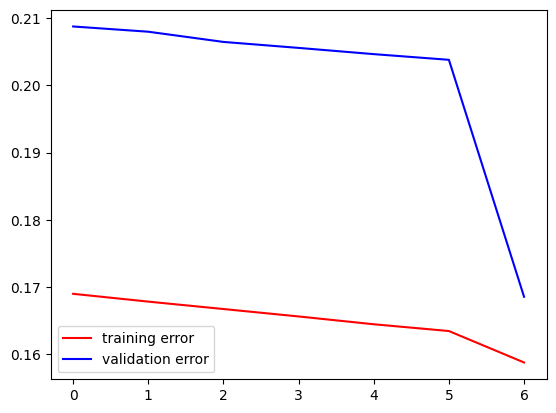

clique size:  38 $k/sqrt{n}$ = [5.0, 4.8, 4.6, 4.4, 4.2, 4.0, 3.8] % correct on test set = [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Percentage of training completed =  0.0 %. Epoch number:  1
epoch index =  0
dim_clique = 36
training error = 0.1586153656244278
validation error = 0.16869619488716125
test error = 0.15160992741584778
--------------------------------------------
Early stop
--------------------------------------------


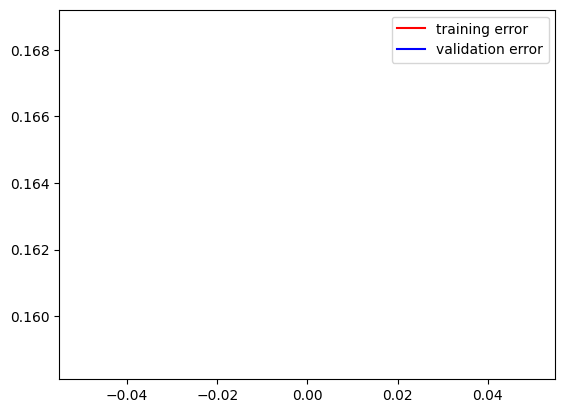

clique size:  36 $k/sqrt{n}$ = [5.0, 4.8, 4.6, 4.4, 4.2, 4.0, 3.8, 3.6] % correct on test set = [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


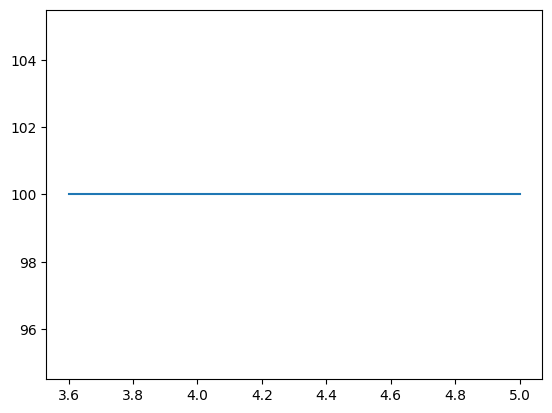

In [37]:
# NN hyperparameters
epochs = 50                    # Number of epochs
max_steps = 30                 # Maximum number of steps for each epoch
num_train = 20                 # Dimension of the training set at each epoch
num_val = 20                   # Dimension of the validation set
num_test = 20                  # Dimension of the test set
training_exit_error = 0.4      # Training error below which we can stop early
validation_exit_error = 0.2    # Validation error below which we can stop early

# Graphs parameters
graph_size = 100               # Number of nodes
start_clique_size = 50         # Dimension of the clique to start training (decreases throughout the epochs)
jump = 2                       # Reduction of the clique size at each epoch
save_step = 5                  # Number of steps after which we check the early stopping criterion
min_clique_size = 35           # Dimension of the clique to finish training (minimum size, never training on graphs with clique size lower than this)

# Initializations
train_error = []
val_error = []
generalization = []
k_over_sqrt_n = []

# Loop for varying (decreasing) clique sizes
for current_clique_size in range(0, start_clique_size - min_clique_size, jump):
  dim_clique = start_clique_size - current_clique_size
  test = generate_graphs(num_test, graph_size, dim_clique)
  k_over_sqrt_n.append(1.0 * dim_clique / math.sqrt(graph_size))
  loss = 1.0
  # initializing training steps counter (increased at every gradient descent step, regardless of epoch)
  step_count = 0

  # Training loop
  for j in range(epochs):

    # inside single epoch
    early_stop_counter=0
    min_validation_loss = np.inf
    train = generate_graphs(num_train, graph_size, dim_clique)
    val = generate_graphs(num_val, graph_size, dim_clique)

    # Gradient descent loop
    for i in range(max_steps):
      # Forward pass
      output = model_d(train[0].to(device))
      # Compute loss
      loss = criterion(output.type(torch.float).to(device), torch.Tensor(train[1]).type(torch.long).to(device))

      # Save error (training and validation errors) at regular intervals (indicated by "save_step")
      if i % save_step == 0:
        print('Percentage of training completed = ', 100.0 * i / max_steps, '%. Epoch number: ', j+1)
        train_error.append(loss.item())
        # Calculate validation loss
        check = model_d(val[0].to(device))
        val_loss = criterion(check.to(device), torch.Tensor(val[1]).type(torch.long).to(device)).item()
        val_error.append(val_loss)

        # Checking if early stopping condition is met
        early_exit, min_validation_loss, early_stop_counter = EarlyStopper(np.array(val_error),early_stop_counter,min_validation_loss)

        if (val_error[step_count] < validation_exit_error or (early_exit and train_error[step_count] < training_exit_error)):
          step_count += 1
          break

        step_count += 1
        # Plotting error curves
        if step_count > 30:
          # Plot error curves for last 30 training steps
          x_axis = np.arange(30)
          fig, ax = plt.subplots()
          ax.plot(x_axis, train_error[step_count - 30:step_count], 'r', label='training error')
          ax.plot(x_axis, val_error[step_count - 30:step_count], 'b', label='validation error')
          ax.legend()
          plt.show()
          print('--------------------------------------------')
        else:
          # Plot error curves for all steps
          x_axis = np.arange(step_count)
          fig, ax = plt.subplots()
          ax.plot(x_axis, train_error[:step_count], 'r', label='training error')
          ax.plot(x_axis, val_error[:step_count], 'b', label='validation error')
          ax.legend()
          plt.show()
          print('--------------------------------------------')

      # Backward pass
      loss.backward()
      # Update weights
      optim.step()
      # Clear gradients
      optim.zero_grad(set_to_none=True)

    # Test error
    test_output = model_d(test[0].to(device))
    test_error = criterion(test_output.to(device), torch.Tensor(test[1]).type(torch.long).to(device))
    if j % 1 == 0:
      print('epoch index = ', j)
      print('dim_clique =', dim_clique)
      print('training error =', train_error[step_count - 1])
      print('validation error =', val_error[step_count - 1])
      print('test error =', test_error.item())
      print('--------------------------------------------')

    # Check if early stopping criterion is met
    if val_error[step_count - 1] < validation_exit_error:
      print('Early stop')
      print('--------------------------------------------')
      break

  # Generating plots for training and validation errors for the current clique size:
  x_axis = np.arange(step_count)
  fig, ax = plt.subplots()
  ax.plot(x_axis, train_error[:step_count], 'r', label='training error')
  ax.plot(x_axis, val_error[:step_count], 'b', label='validation error')
  ax.legend()
  plt.show()

  # Clearing the lists storing training and validation errors
  train_error = []
  val_error = []

  # Generating test data
  data = test
  hard_output = torch.zeros([num_test, 2])  #initialize tensor to store hard predictions
  soft_output = model_d(data[0].to(device)) #performing forward pass on test data

  # Converting soft predictions to hard predictions:
  for l in range(num_test):
    if soft_output[l][0] > soft_output[l][1]:
      hard_output[l][0] = 1.0
    else:
      hard_output[l][1] = 1.0
  predicted_output = hard_output

  # Transposing the predicted output and calculating test error:
  generalization.append(
      100 * (1 - torch.sum(torch.square(torch.Tensor(data[1]) - torch.transpose(predicted_output, 1, 0)[1])).item() / (
                  1.0 * num_test)))
  # Printing the current k/sqrt(n) and corresponding test error:
  print('clique size: ',dim_clique, '$k/sqrt{n}$ =', k_over_sqrt_n, '% correct on test set =', generalization)
  print('==========================================')


plt.plot(k_over_sqrt_n, generalization)

Here we check the generalization error and we compute the transition at which the network starts to fail.

k = 85 ----> % = 100.0
k = 84 ----> % = 100.0
k = 83 ----> % = 100.0
k = 82 ----> % = 100.0
k = 81 ----> % = 100.0
k = 80 ----> % = 100.0
k = 79 ----> % = 100.0
k = 78 ----> % = 100.0
k = 77 ----> % = 100.0
k = 76 ----> % = 100.0
k = 75 ----> % = 100.0
k = 74 ----> % = 100.0
k = 73 ----> % = 100.0
k = 72 ----> % = 100.0
k = 71 ----> % = 100.0
k = 70 ----> % = 100.0
k = 69 ----> % = 100.0
k = 68 ----> % = 100.0
k = 67 ----> % = 100.0
k = 66 ----> % = 100.0
k = 65 ----> % = 100.0
k = 64 ----> % = 100.0
k = 63 ----> % = 100.0
k = 62 ----> % = 100.0
k = 61 ----> % = 100.0
k = 60 ----> % = 100.0
k = 59 ----> % = 100.0
k = 58 ----> % = 100.0
k = 57 ----> % = 100.0
k = 56 ----> % = 100.0
k = 55 ----> % = 100.0
k = 54 ----> % = 100.0
k = 53 ----> % = 100.0
k = 52 ----> % = 100.0
k = 51 ----> % = 100.0
k = 50 ----> % = 100.0
k = 49 ----> % = 100.0
k = 48 ----> % = 100.0
k = 47 ----> % = 100.0
k = 46 ----> % = 100.0
k = 45 ----> % = 98.66666666666667
k = 44 ----> % = 100.0
k = 43 ----> % = 100.0

k = 3 ----> % = 49.0
k over sqrt(n) = [8.5, 8.4, 8.3, 8.2, 8.1, 8.0, 7.9, 7.8, 7.7, 7.6, 7.5, 7.4, 7.3, 7.2, 7.1, 7.0, 6.9, 6.8, 6.7, 6.6, 6.5, 6.4, 6.3, 6.2, 6.1, 6.0, 5.9, 5.8, 5.7, 5.6, 5.5, 5.4, 5.3, 5.2, 5.1, 5.0, 4.9, 4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2, 4.1, 4.0, 3.9, 3.8, 3.7, 3.6, 3.5, 3.4, 3.3, 3.2, 3.1, 3.0, 2.9, 2.8, 2.7, 2.6, 2.5, 2.4, 2.3, 2.2, 2.1, 2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3] % = [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 98.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.33333333333333, 100.0, 99.33333333333333, 99.33333333333333, 97.33333333333333, 98.0, 98.0, 96.66666666666667, 95.66666666666667, 96.6

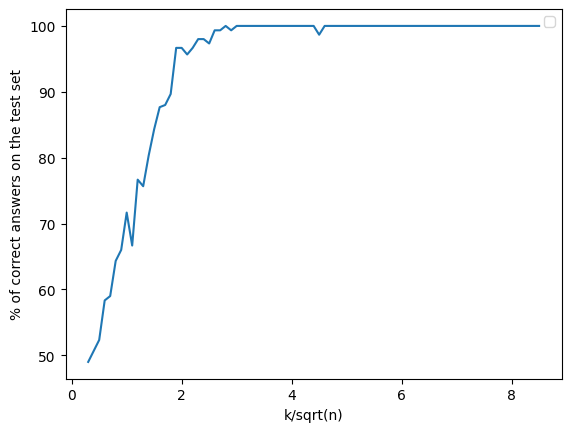

In [38]:
start_dim_clique = 85
times = 15

generalization_MLP = []
k_vs_sqrt_n_MLP = []

for m in range(0,start_dim_clique-2,1):
  dim_clique = start_dim_clique - m
  k_vs_sqrt_n_MLP.append(1.0*dim_clique/math.sqrt(graph_size))
  mean = 0

  for j in range(times):
    data = generate_graphs(num_train,graph_size,dim_clique)
    hard_output = torch.zeros([num_test,2])

    soft_output = model_d(data[0].to(device))
    for l in range(num_test):
      if (soft_output[l][0] > soft_output[l][1]):
        hard_output[l][0] = 1.0
      else: hard_output[l][1] = 1.0
    predicted_output = hard_output

    mean = mean + 100*(1-torch.sum(torch.square(torch.Tensor(data[1])-torch.transpose(predicted_output,1,0)[1])).item()/(1.0*num_test))

  mean = mean/times
  generalization_MLP.append(mean)
  print('k =',dim_clique,'---->', '% =', mean)
  print('==========================================')
print('k over sqrt(n) =', list(k_vs_sqrt_n_MLP), '% =', list(generalization_MLP))
print('==========================================')

fig, ax = plt.subplots()
ax.plot(k_vs_sqrt_n_MLP,generalization_MLP)
plt.xlabel('k/sqrt(n)')
plt.ylabel('% of correct answers on the test set')
ax.legend()
plt.show()

# Convolutional Neural Networks (CNNs)

Using the functions that generate the graphs we can represent the adjacency matrices as images. For instance let's see two images, one representing a graphs of size $n=60$ with a planted clique of size $k=30$ and the other without it. Can you tell the difference?

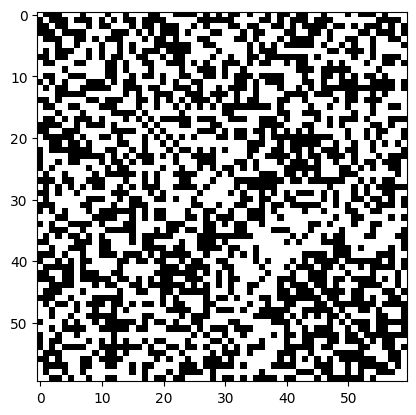

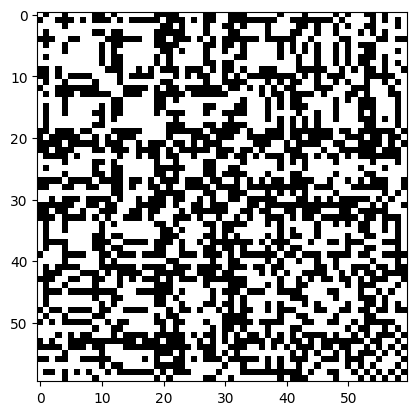

In [ ]:
image_1 = PlantedClique(60,0.5,30,0,1)
image_0 = PlantedClique(60,0.5,30,1,1)

fig, ax = plt.subplots()
ax.imshow(image_1[0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
fig, ax = plt.subplots()
ax.imshow(image_0[0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

Here we define the CNN. The meaning of each parameter is explained below. This network works only with graphs of a certain size (in this case $n=100$), a different graph needs a slightely different architecture. There is also an early stopping function, which stops if the validation error starts to increase for several steps.

The architecture is basically just a combination of convolutional al pooling layers with kernels of size 3. The optimizier is Adam and the loss is the CrossEntropy.

In [ ]:
lr_rate=0.01            # learning rate
c1=5                    # first convolution layer
c2=10                   # second convolution layer
c3=15                   # third convolution layer
c4=20                   # fourth convolution layer
l3=100                  # linear layer
d=0.2                   # dropout probability
kernel = 3              # kernel size

#function for the early stopping
def EarlyStopper(validation_loss, counter, min_validation_loss, past=3, patience=6, min_delta=0.02):
        length = validation_loss.shape[0]
        if np.mean(validation_loss[length-past:]) < min_validation_loss and length > past:
            min_validation_loss = np.mean(validation_loss[length-past:])
            counter = 0
        elif np.mean(validation_loss[length-past:]) > (min_validation_loss + min_delta) and length > past:
            counter += 1
            if counter >= patience:
                return True, min_validation_loss, counter
        return False, min_validation_loss, counter

#2d convolution with batch normalization and ReLU activation
def convbn(ci,co,ksz,s=1,pz=0):
    return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz,padding_mode = 'circular'),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

#residual block
class Residual(nn.Module):
  def __init__(self, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
    stride=strides)
    self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
      stride=strides)
    else:
      self.conv3 = None
      self.bn1 = nn.LazyBatchNorm2d()
      self.bn2 = nn.LazyBatchNorm2d()

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

# Definition of the CNN architecture
model = nn.Sequential(
            nn.Dropout(0.2),
            convbn(1,c1,kernel,1,1),
            nn.Dropout(d),
            nn.MaxPool2d(kernel),
            Residual(c1),
            convbn(c1,c2,kernel,1,1),
            nn.Dropout(d),
            nn.MaxPool2d(kernel),
            Residual(c2),
            convbn(c2,c3,kernel,1,1),
            nn.Dropout(d),
            nn.MaxPool2d(kernel),
            #Residual(c3),
            #convbn(c3,c4,kernel,1,1),
            #nn.MaxPool2d(kernel),
            nn.Flatten(),
            nn.Linear(135, l3),
            nn.ReLU(),
            nn.Linear(l3, 2),
            nn.ReLU()
            )

optim=torch.optim.Adam(model.parameters())   # optimization with Adam
criterion = nn.CrossEntropyLoss()            # criterion = Cross Entropy
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Dropout(p=0.2, inplace=False)
  (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (4): Residual(
    (conv1): LazyConv2d(0, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): LazyConv2d(0, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): Sequential(
    (0): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats

The following is the traing procedure. It works in the following way: at each epoch we generate a batch of training samples. Then we train the network with this batch and check the validation error. This online generation of batches ensures a faster training.

Eventually we also plot the generalization error versus the parameter $k/n$.

If you want to run the code test with small number of epochs, small max_step or smaller samples; the code takes very long.

Training = 0.0 %


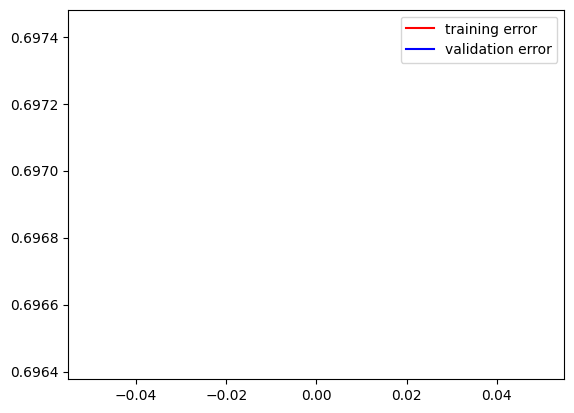

--------------------------------------------
Training = 5.0 %


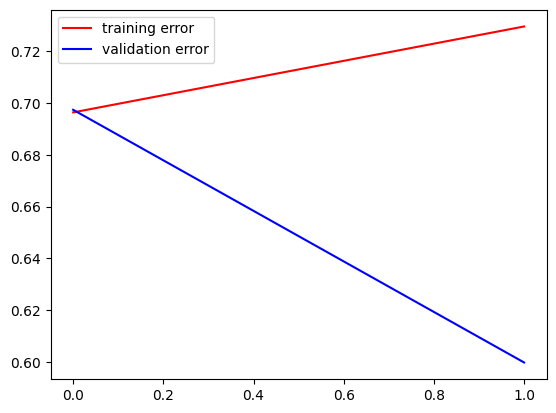

--------------------------------------------
Training = 10.0 %


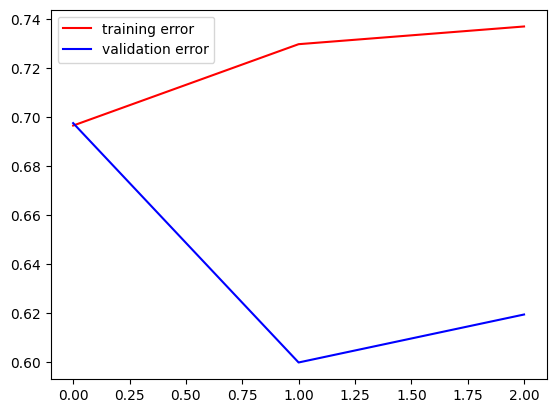

--------------------------------------------
Training = 15.0 %


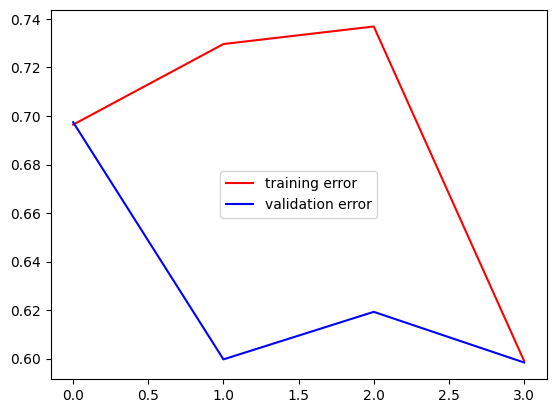

--------------------------------------------
Training = 20.0 %


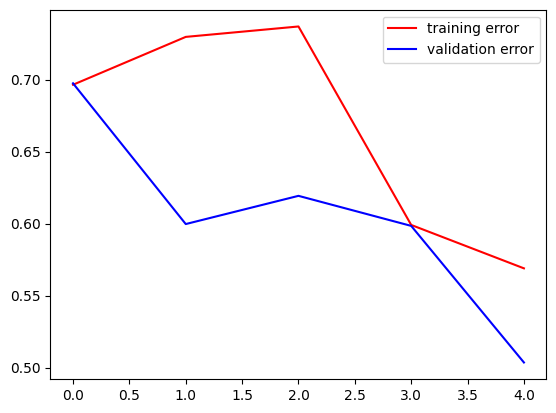

--------------------------------------------
Training = 25.0 %


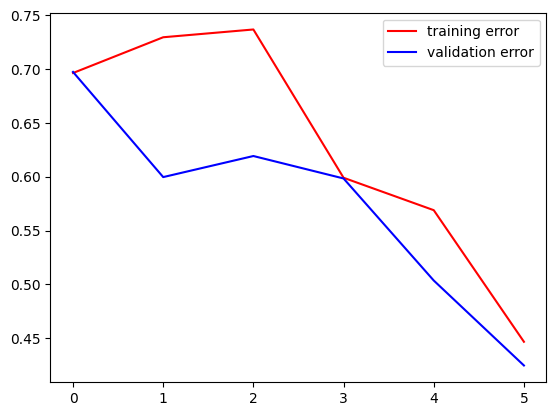

--------------------------------------------
Training = 30.0 %


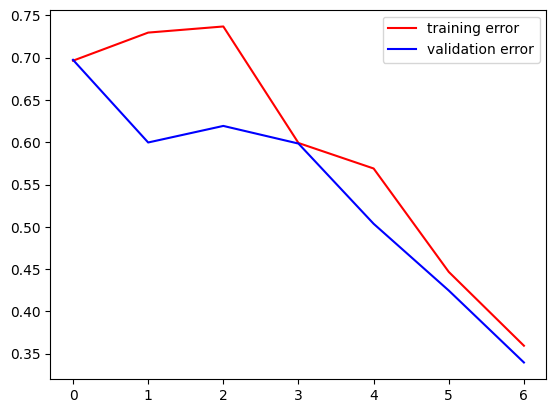

--------------------------------------------
Training = 35.0 %


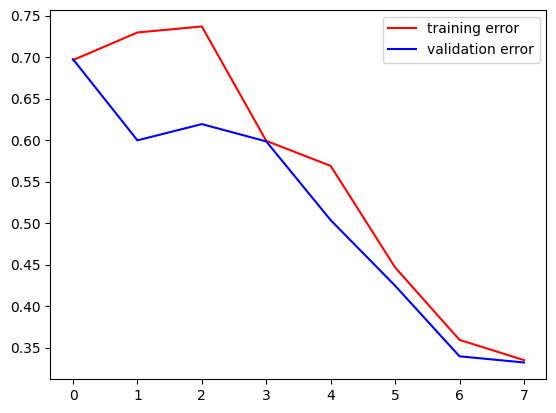

--------------------------------------------
Training = 40.0 %


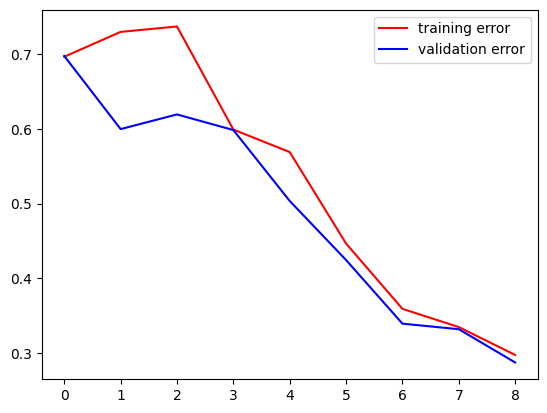

--------------------------------------------
Training = 45.0 %


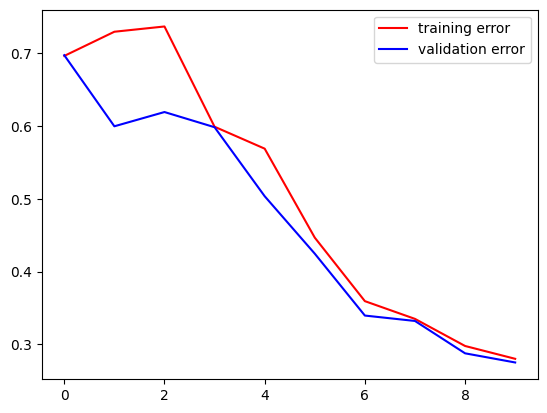

--------------------------------------------
Training = 50.0 %


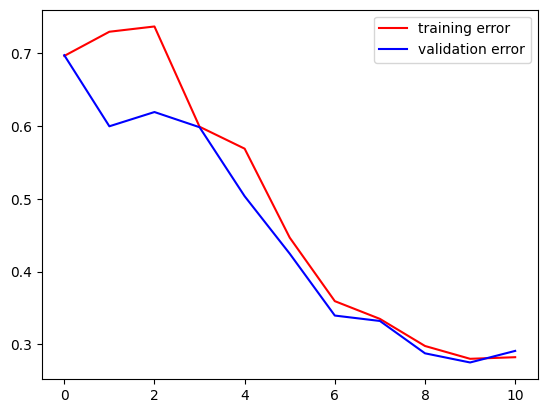

--------------------------------------------
Training = 55.0 %


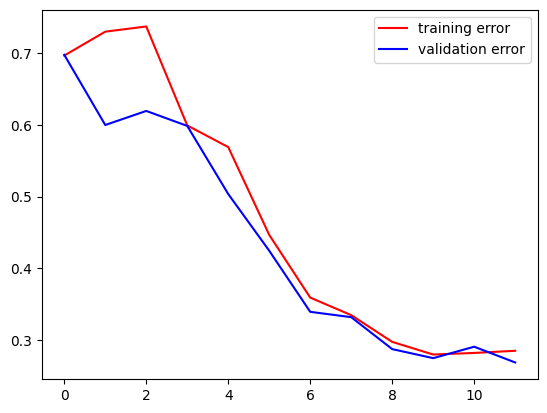

--------------------------------------------
Training = 60.0 %


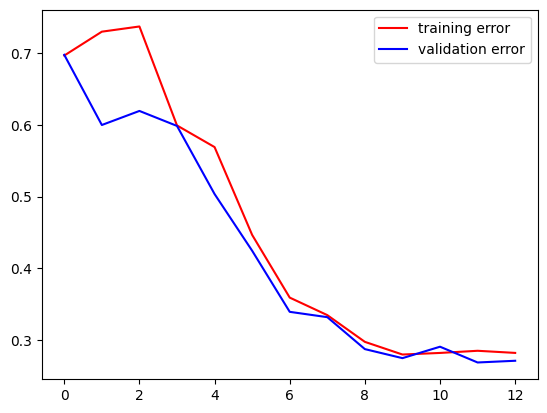

--------------------------------------------
Training = 65.0 %


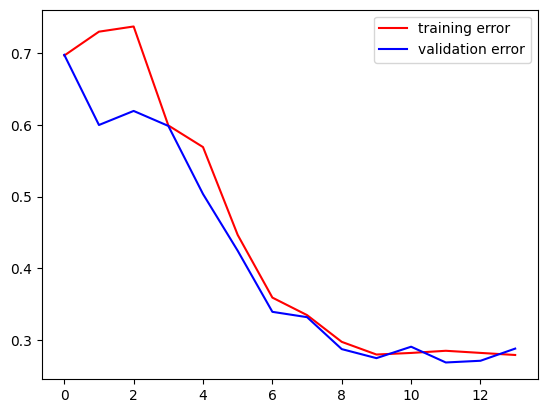

--------------------------------------------
Training = 70.0 %


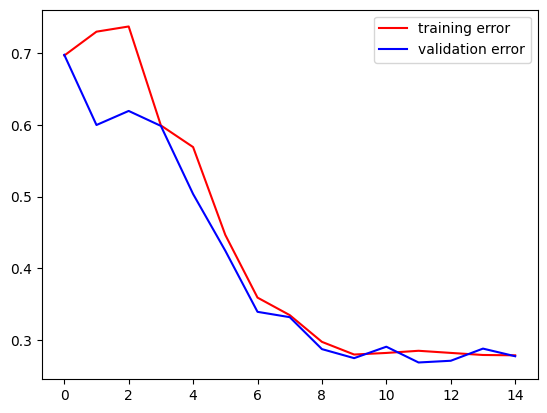

--------------------------------------------
Training = 75.0 %


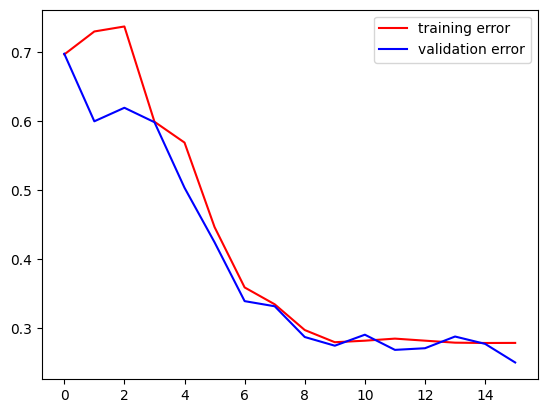

--------------------------------------------
Training = 80.0 %


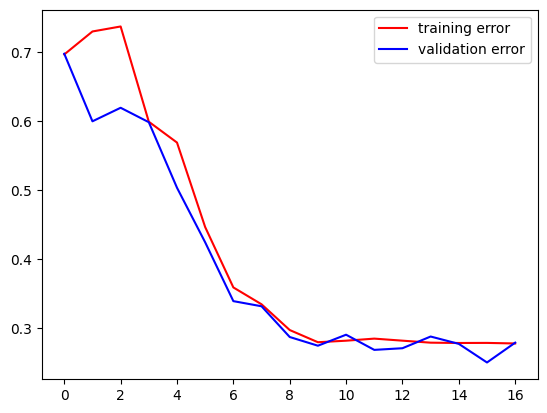

--------------------------------------------
Training = 85.0 %


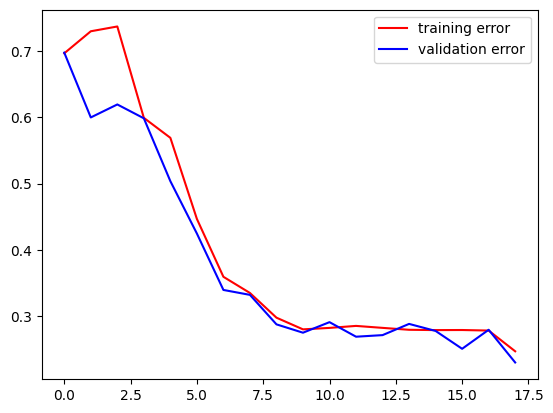

--------------------------------------------
Training = 90.0 %
epoch = 0
dim_clique = 50
training error = 0.04082709550857544
validation error = 0.06358062475919724
test error = 0.05526072531938553
--------------------------------------------
Early stop
--------------------------------------------


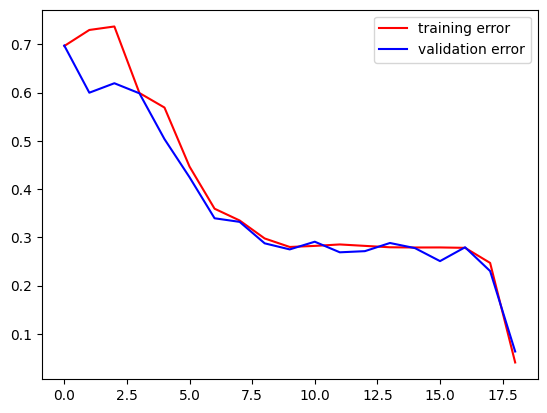

k/n = [5.0] % = [100.0]
Training = 0.0 %
epoch = 0
dim_clique = 48
training error = 0.13917678594589233
validation error = 0.062353719025850296
test error = 0.07658801972866058
--------------------------------------------
Early stop
--------------------------------------------


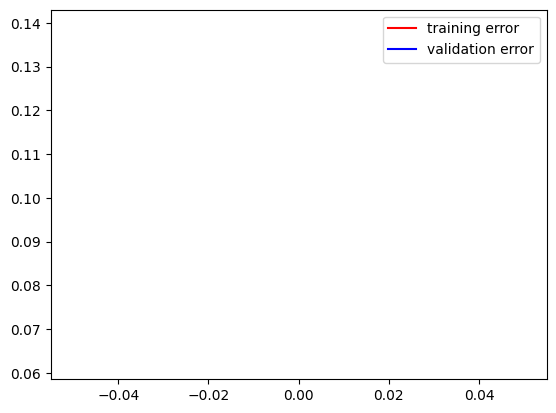

k/n = [5.0, 4.8] % = [100.0, 100.0]
Training = 0.0 %
epoch = 0
dim_clique = 46
training error = 0.10106194019317627
validation error = 0.07713551819324493
test error = 0.06837926805019379
--------------------------------------------
Early stop
--------------------------------------------


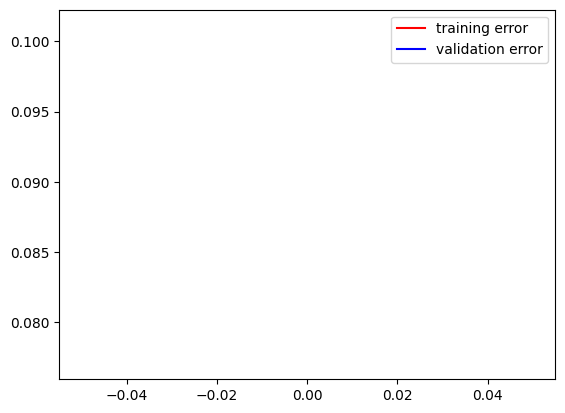

k/n = [5.0, 4.8, 4.6] % = [100.0, 100.0, 100.0]
Training = 0.0 %


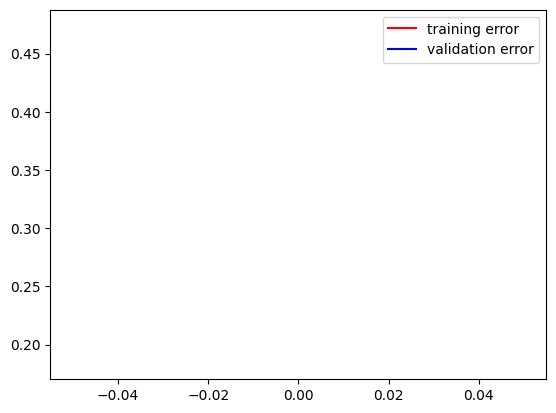

--------------------------------------------
Training = 5.0 %


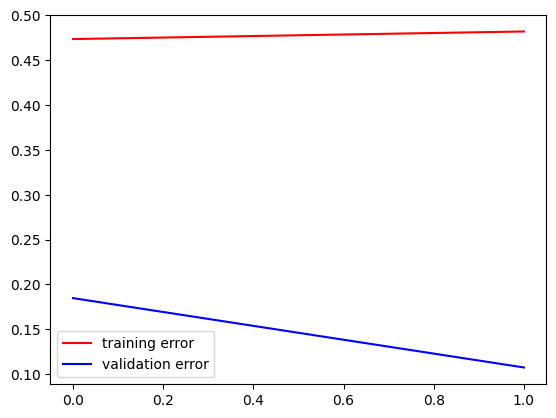

--------------------------------------------
Training = 10.0 %


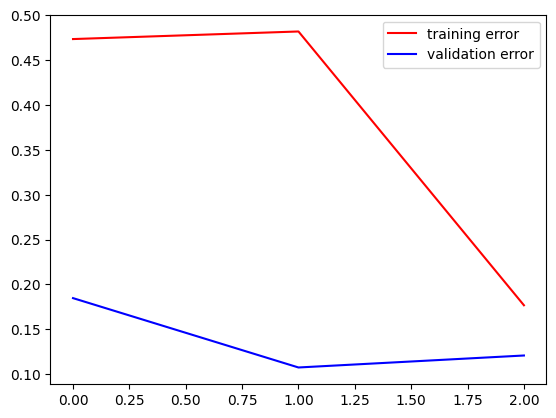

--------------------------------------------
Training = 15.0 %


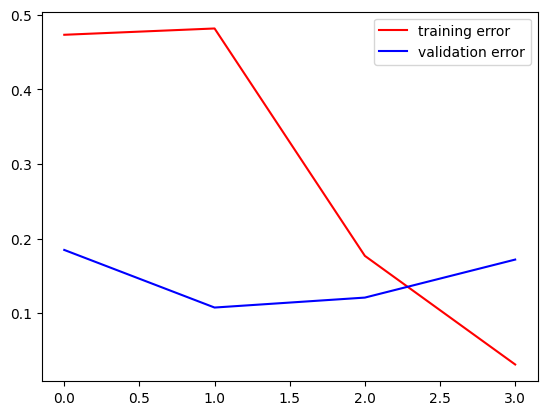

--------------------------------------------
Training = 20.0 %
epoch = 0
dim_clique = 44
training error = 0.02694793976843357
validation error = 0.09714914113283157
test error = 0.041865818202495575
--------------------------------------------
Early stop
--------------------------------------------


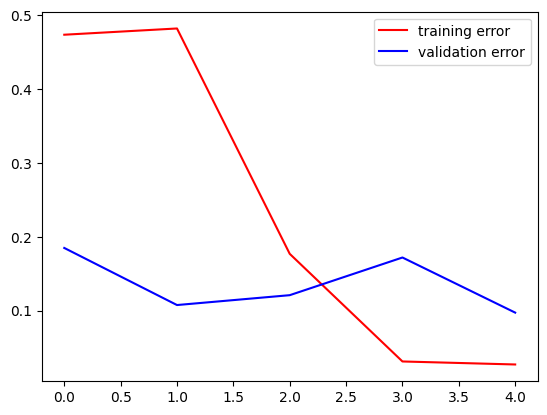

k/n = [5.0, 4.8, 4.6, 4.4] % = [100.0, 100.0, 100.0, 100.0]
Training = 0.0 %


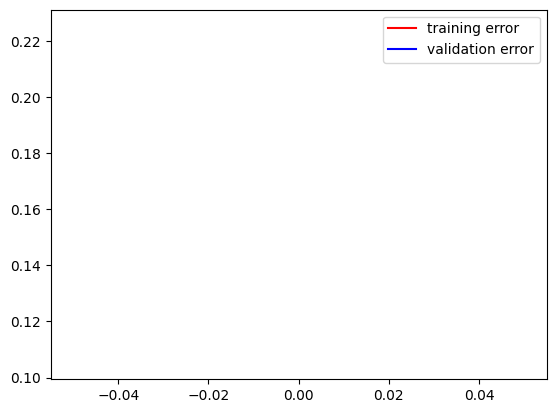

--------------------------------------------
Training = 5.0 %


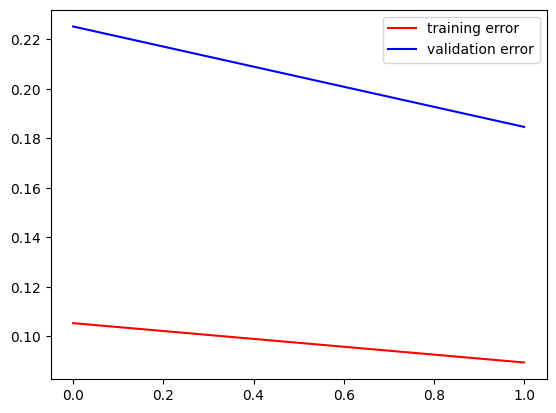

--------------------------------------------
Training = 10.0 %


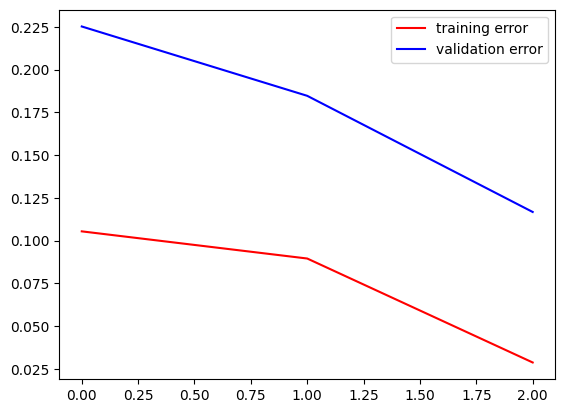

--------------------------------------------
Training = 15.0 %
epoch = 0
dim_clique = 42
training error = 0.09407337754964828
validation error = 0.026119977235794067
test error = 0.7212567329406738
--------------------------------------------
Early stop
--------------------------------------------


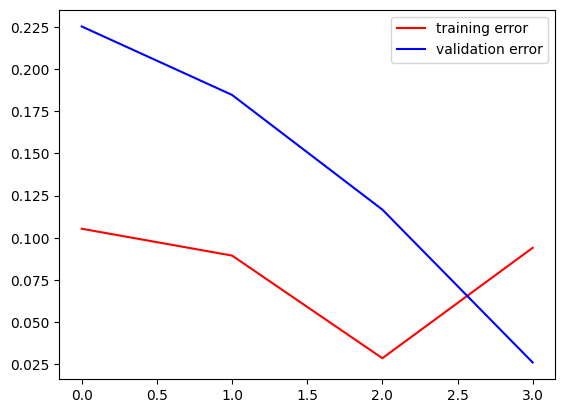

k/n = [5.0, 4.8, 4.6, 4.4, 4.2] % = [100.0, 100.0, 100.0, 100.0, 65.0]
Training = 0.0 %
epoch = 0
dim_clique = 40
training error = 0.5620248317718506
validation error = 0.059691764414310455
test error = 0.061721909791231155
--------------------------------------------
Early stop
--------------------------------------------


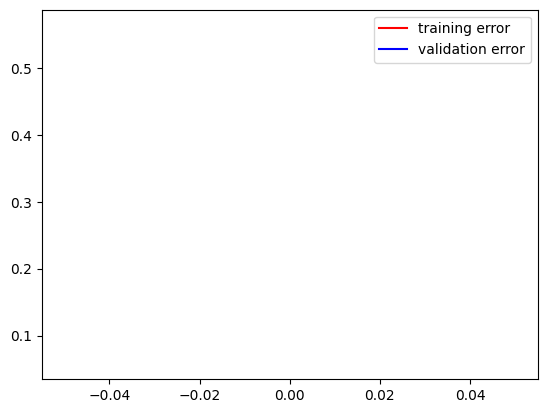

k/n = [5.0, 4.8, 4.6, 4.4, 4.2, 4.0] % = [100.0, 100.0, 100.0, 100.0, 65.0, 90.0]
Training = 0.0 %


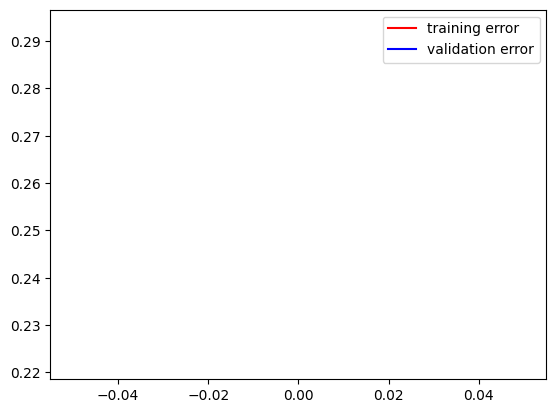

--------------------------------------------
Training = 5.0 %


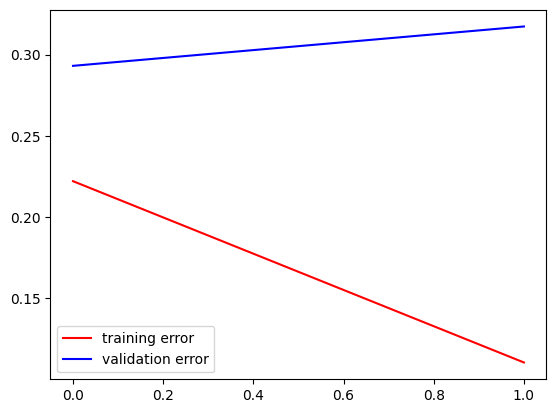

--------------------------------------------
Training = 10.0 %


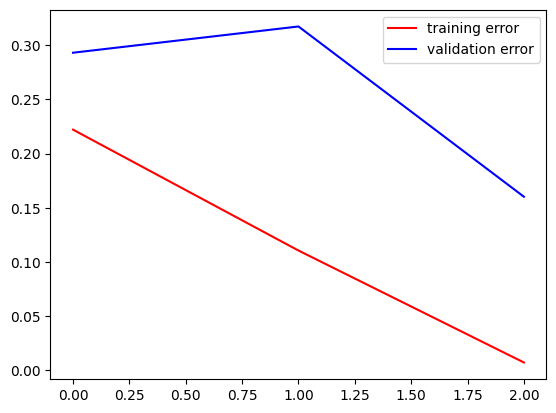

--------------------------------------------
Training = 15.0 %
epoch = 0
dim_clique = 38
training error = 0.01614605449140072
validation error = 0.08234761655330658
test error = 0.1360597312450409
--------------------------------------------
Early stop
--------------------------------------------


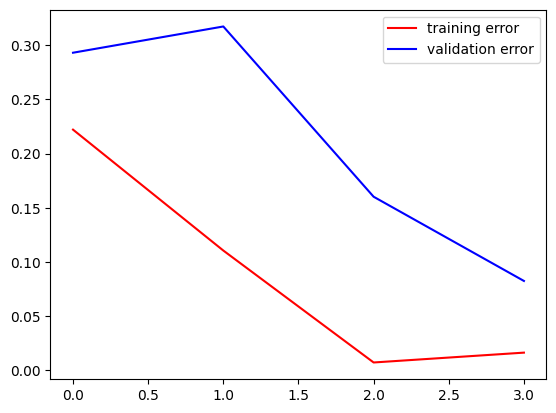

k/n = [5.0, 4.8, 4.6, 4.4, 4.2, 4.0, 3.8] % = [100.0, 100.0, 100.0, 100.0, 65.0, 90.0, 90.0]
Training = 0.0 %


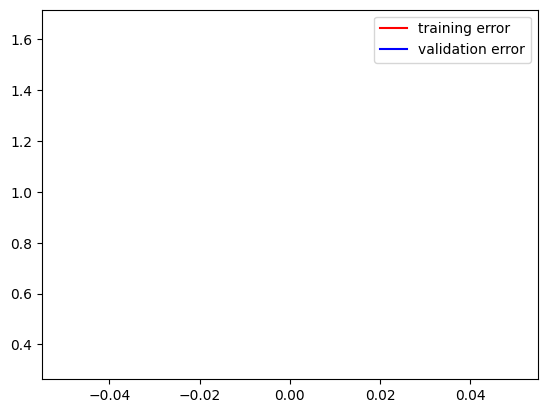

--------------------------------------------
Training = 5.0 %


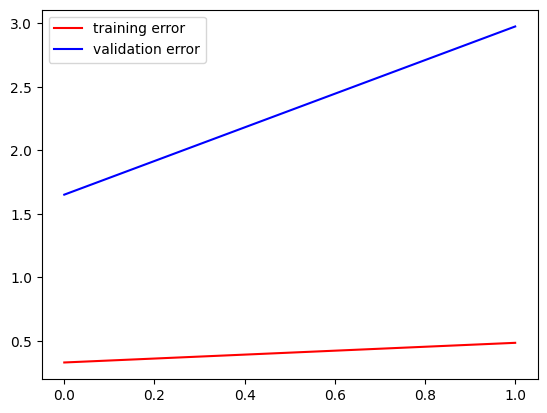

--------------------------------------------
Training = 10.0 %


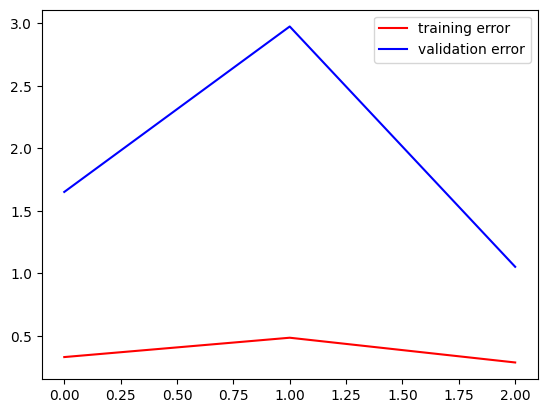

--------------------------------------------
Training = 15.0 %


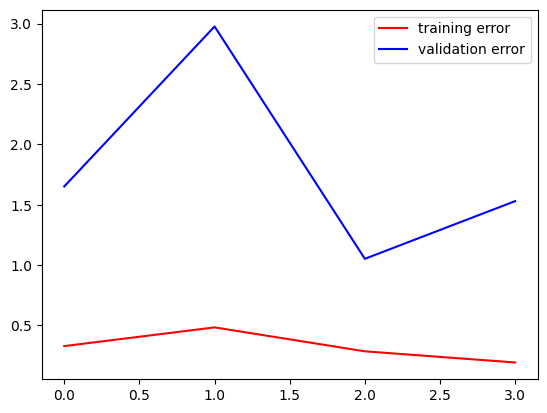

--------------------------------------------
Training = 20.0 %


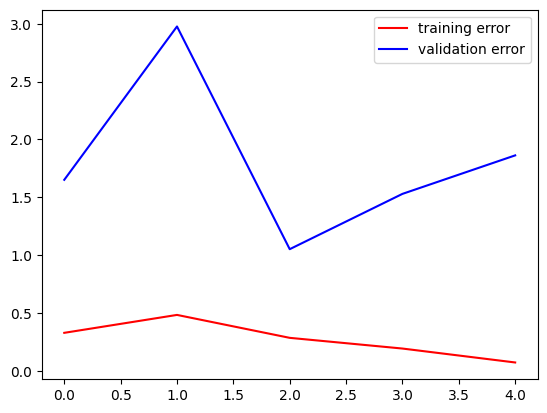

--------------------------------------------
Training = 25.0 %


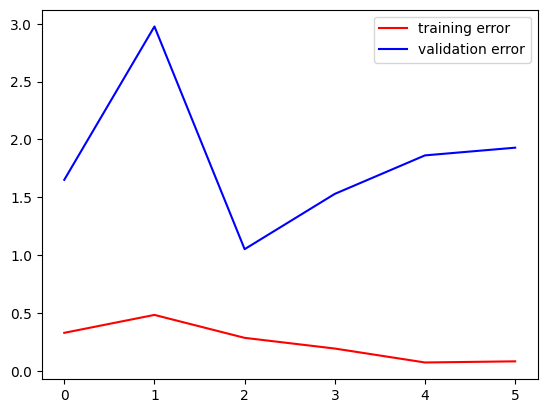

--------------------------------------------
Training = 30.0 %


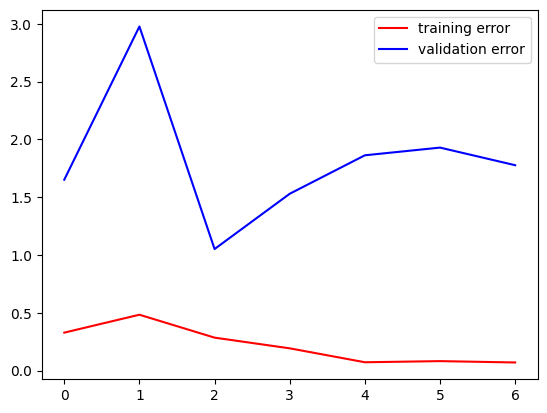

--------------------------------------------
Training = 35.0 %


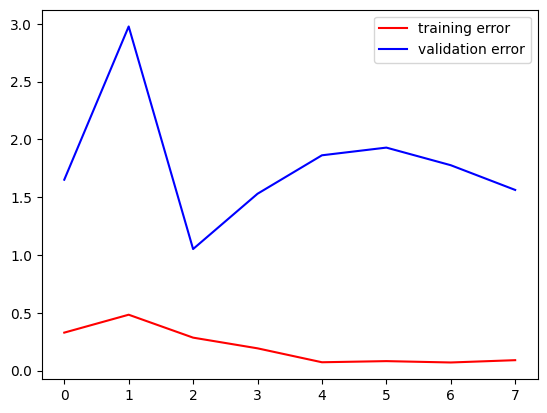

--------------------------------------------
Training = 40.0 %


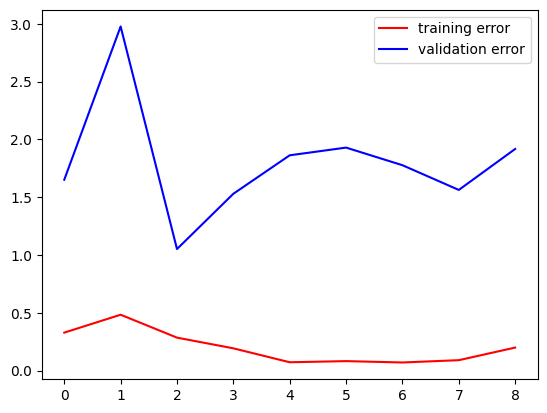

--------------------------------------------
Training = 45.0 %


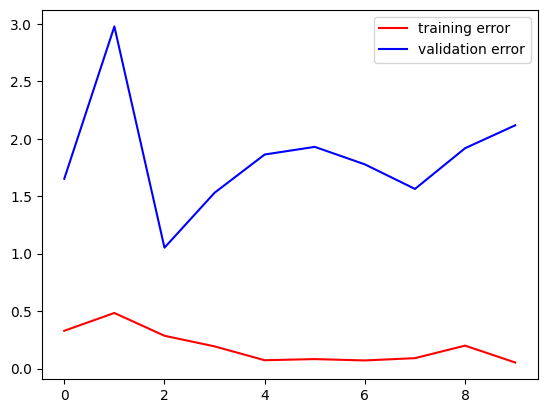

--------------------------------------------
Training = 50.0 %
epoch = 0
dim_clique = 36
training error = 0.15934361517429352
validation error = 1.6623680591583252
test error = 0.20275700092315674
--------------------------------------------
Training = 0.0 %


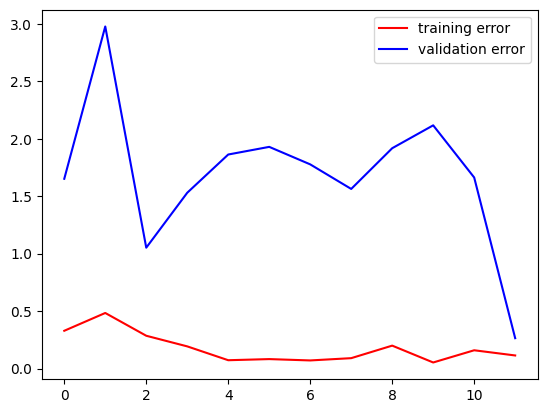

--------------------------------------------
Training = 5.0 %


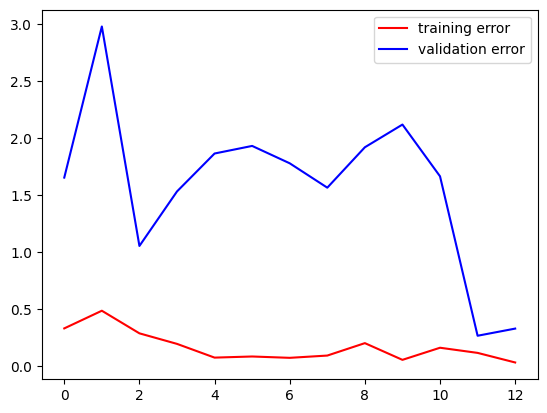

--------------------------------------------
Training = 10.0 %


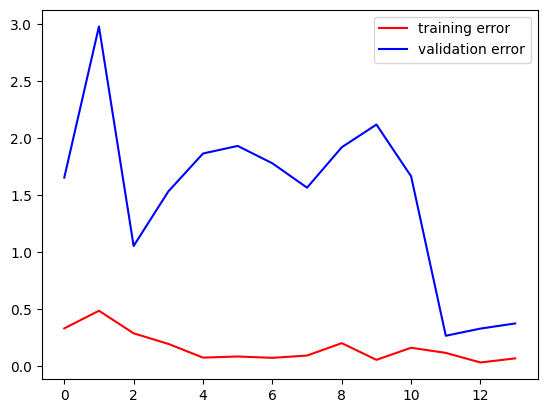

--------------------------------------------
Training = 15.0 %


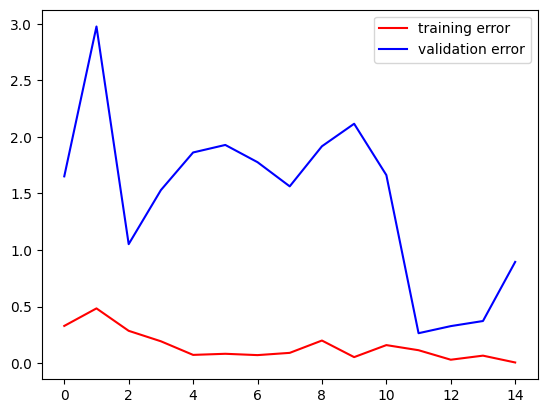

--------------------------------------------
Training = 20.0 %


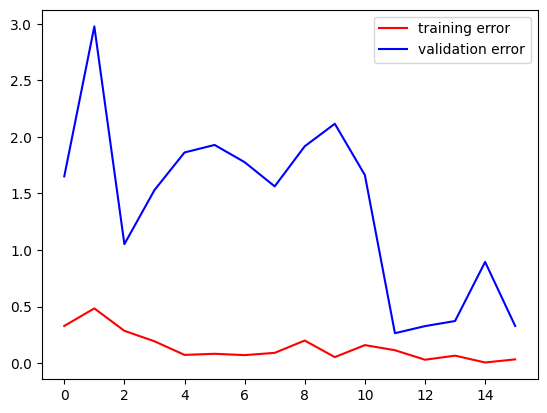

--------------------------------------------
Training = 25.0 %
epoch = 1
dim_clique = 36
training error = 0.010773077607154846
validation error = 0.05988454073667526
test error = 0.09617073088884354
--------------------------------------------
Early stop
--------------------------------------------


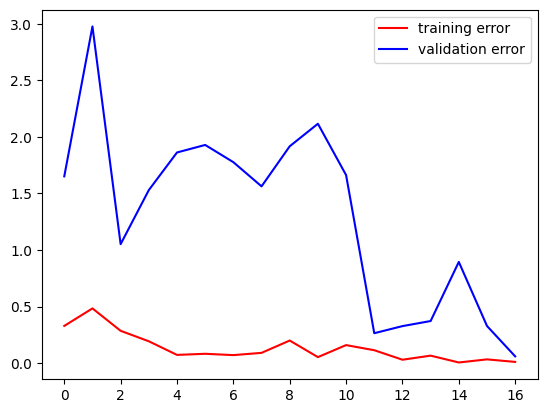

k/n = [5.0, 4.8, 4.6, 4.4, 4.2, 4.0, 3.8, 3.6] % = [100.0, 100.0, 100.0, 100.0, 65.0, 90.0, 90.0, 95.0]
Training = 0.0 %


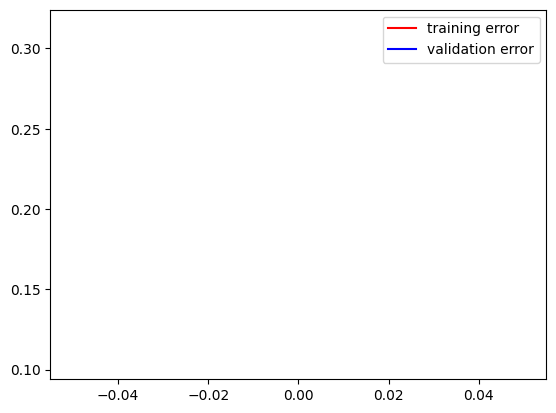

--------------------------------------------
Training = 5.0 %


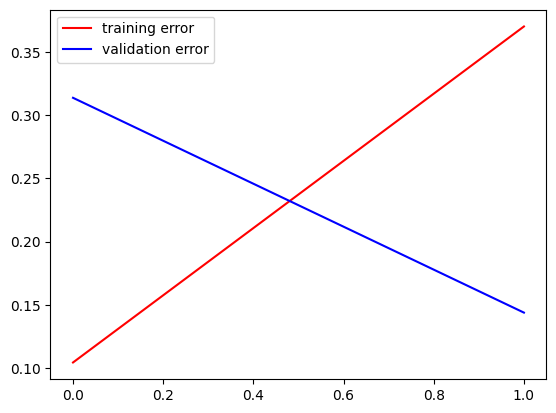

--------------------------------------------
Training = 10.0 %
epoch = 0
dim_clique = 34
training error = 0.16236110031604767
validation error = 0.09587958455085754
test error = 0.364413321018219
--------------------------------------------
Early stop
--------------------------------------------


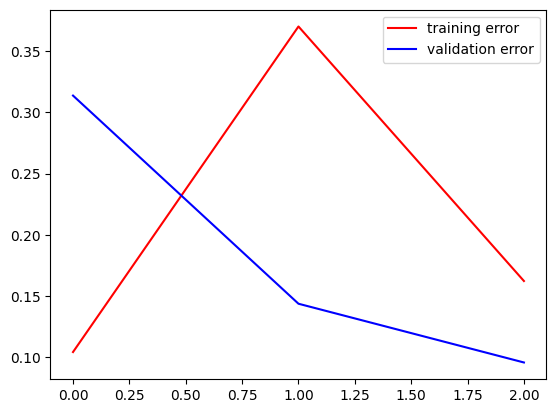

k/n = [5.0, 4.8, 4.6, 4.4, 4.2, 4.0, 3.8, 3.6, 3.4] % = [100.0, 100.0, 100.0, 100.0, 65.0, 90.0, 90.0, 95.0, 90.0]
Training = 0.0 %


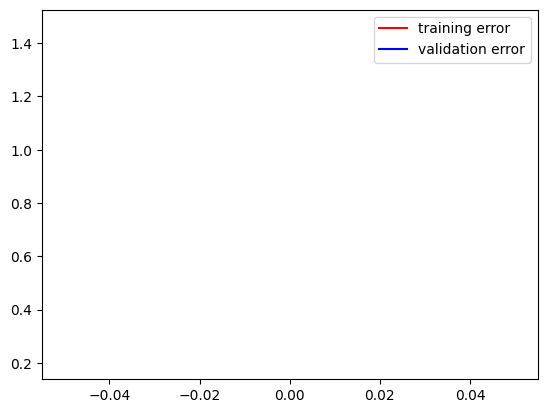

--------------------------------------------
Training = 5.0 %


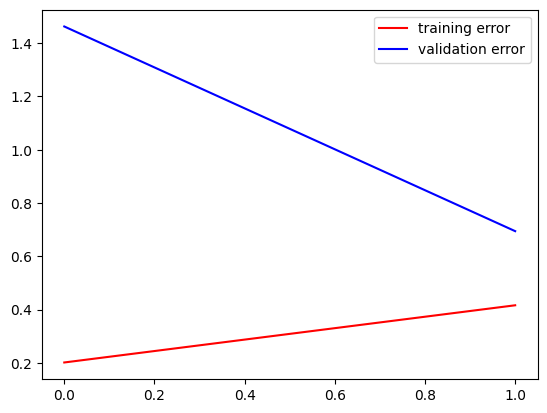

--------------------------------------------
Training = 10.0 %


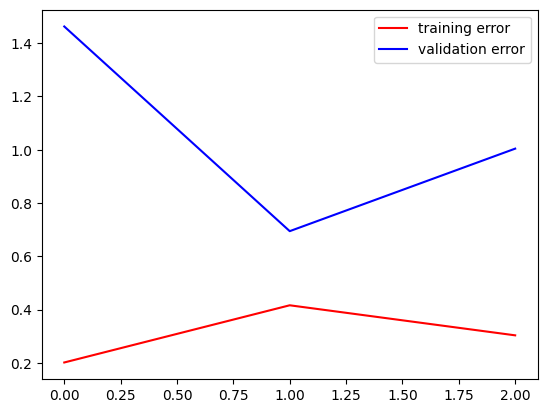

--------------------------------------------
Training = 15.0 %


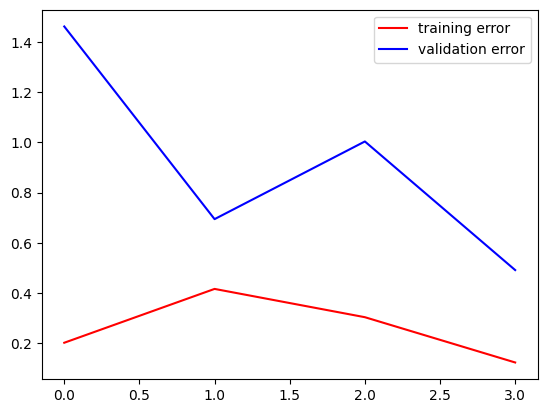

--------------------------------------------
Training = 20.0 %


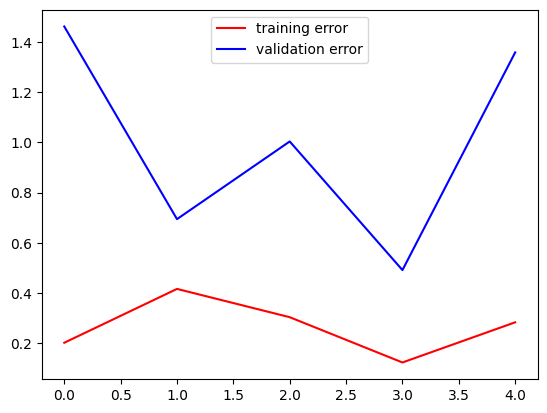

--------------------------------------------
Training = 25.0 %


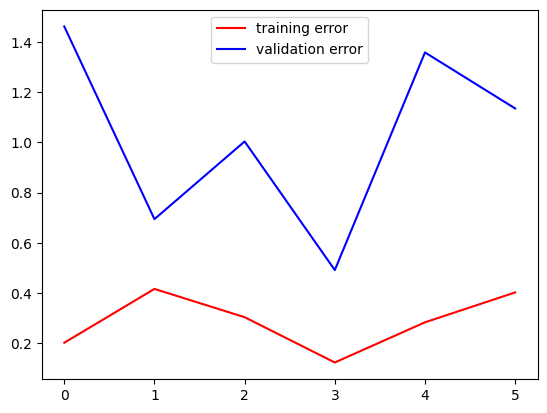

--------------------------------------------
Training = 30.0 %


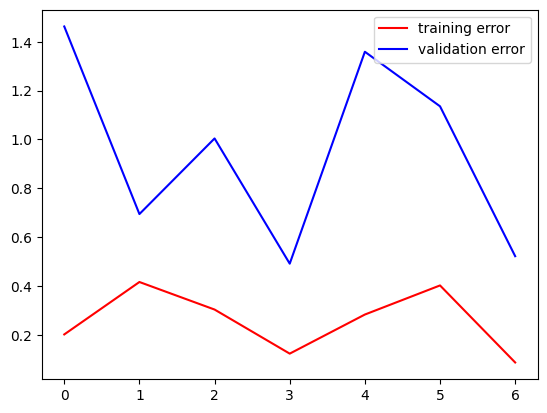

--------------------------------------------
Training = 35.0 %


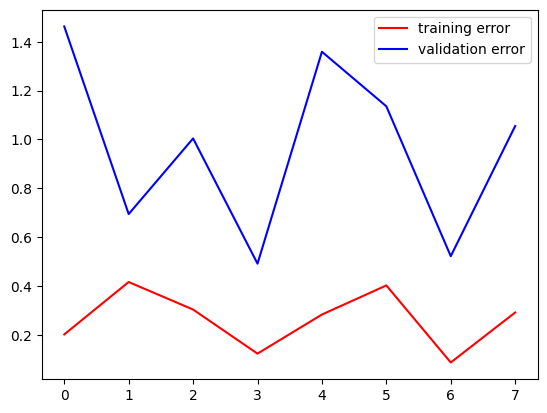

--------------------------------------------
Training = 40.0 %


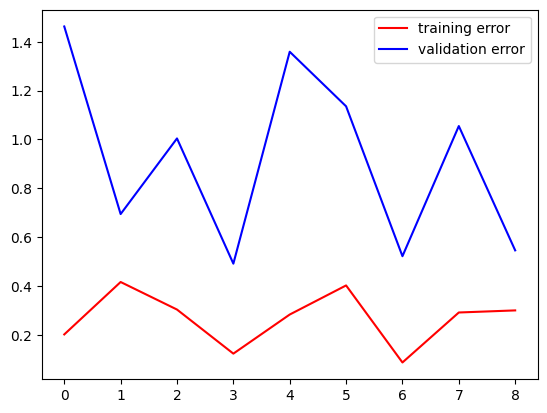

--------------------------------------------
Training = 45.0 %


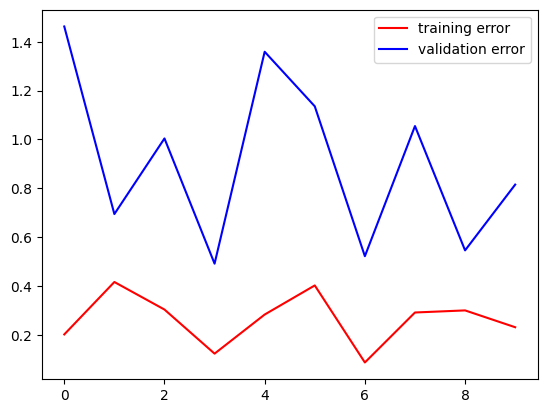

--------------------------------------------
Training = 50.0 %


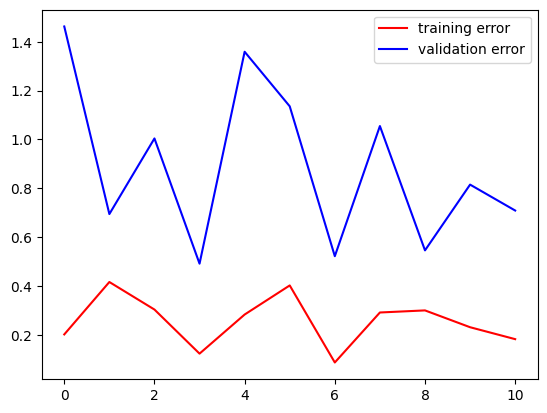

--------------------------------------------
Training = 55.0 %


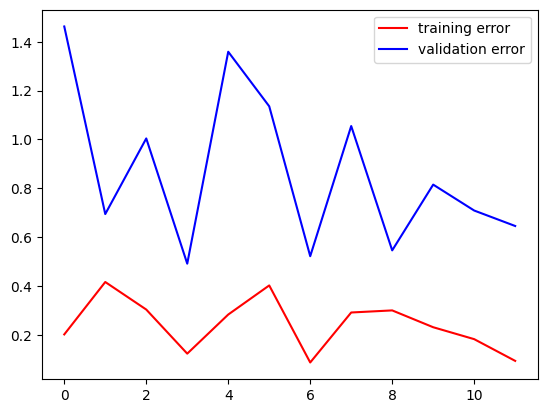

--------------------------------------------
Training = 60.0 %


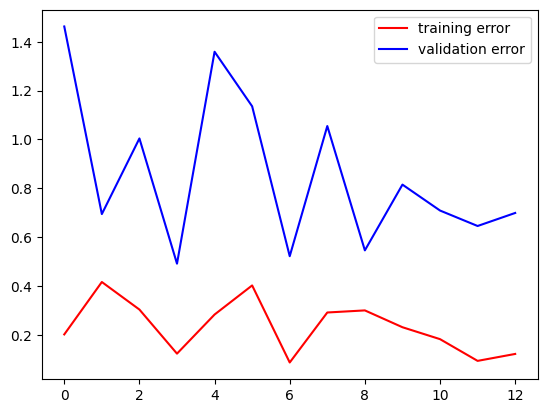

--------------------------------------------
Training = 65.0 %


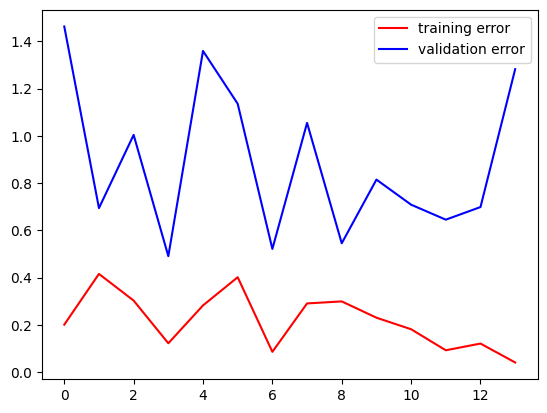

--------------------------------------------
Training = 70.0 %


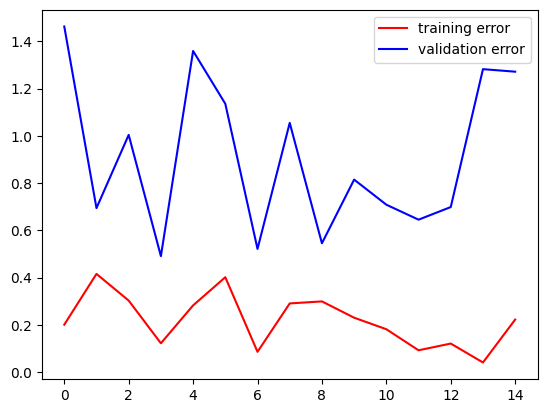

--------------------------------------------
Training = 75.0 %


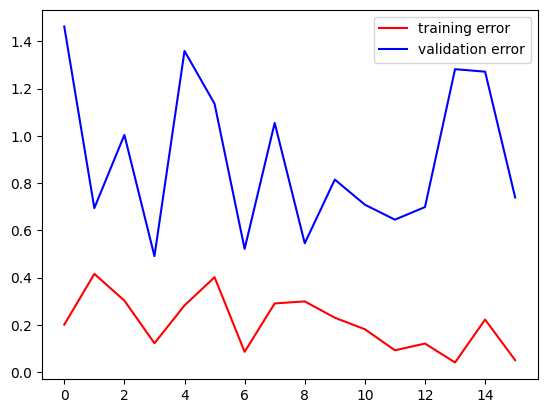

--------------------------------------------
Training = 80.0 %


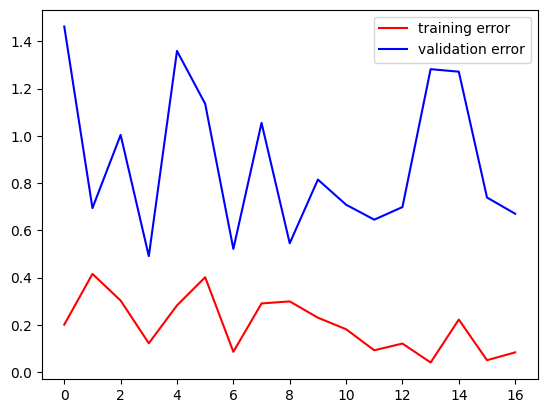

--------------------------------------------
Training = 85.0 %


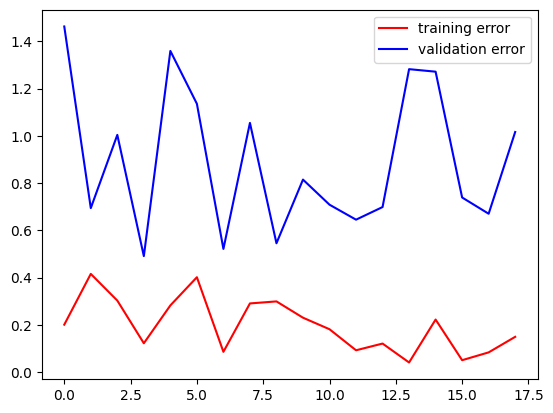

--------------------------------------------
Training = 90.0 %
epoch = 0
dim_clique = 32
training error = 0.044188328087329865
validation error = 1.2257717847824097
test error = 0.3286413252353668
--------------------------------------------
Training = 0.0 %


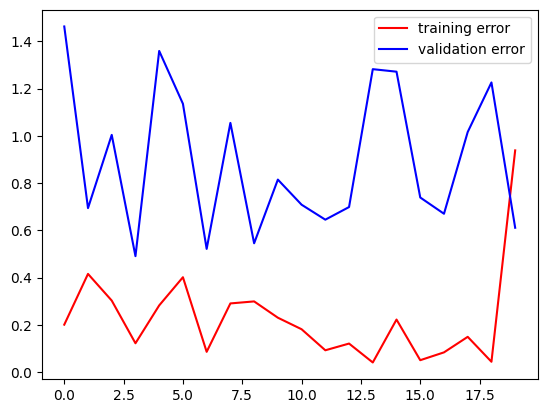

--------------------------------------------
Training = 5.0 %


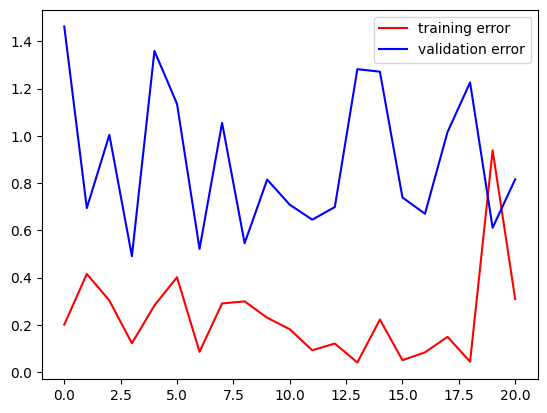

--------------------------------------------
Training = 10.0 %


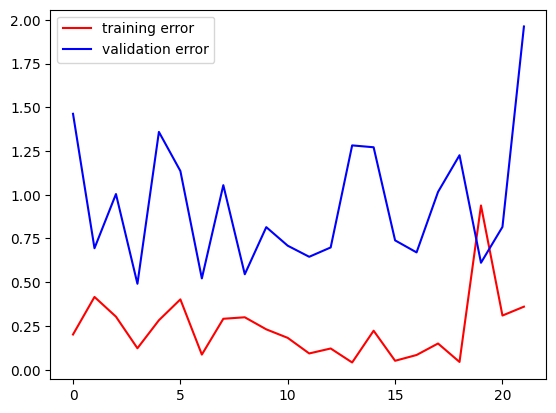

--------------------------------------------
Training = 15.0 %


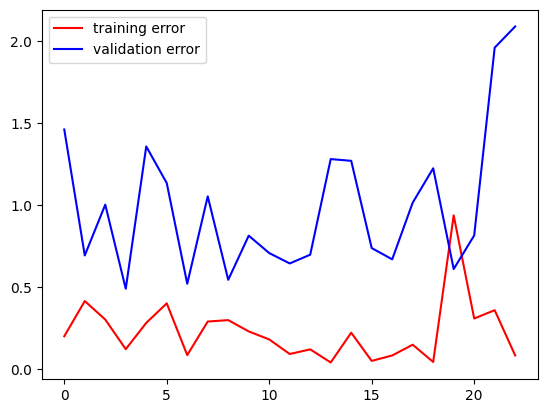

--------------------------------------------
Training = 20.0 %


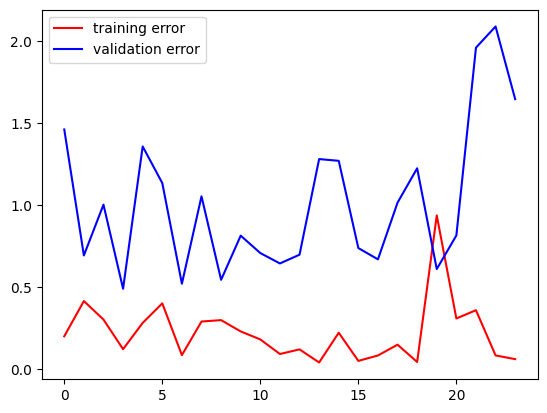

--------------------------------------------
Training = 25.0 %


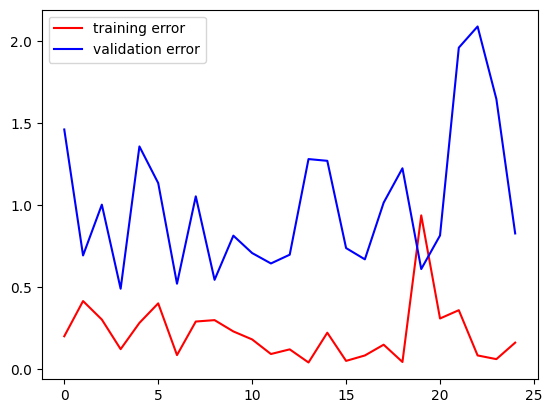

--------------------------------------------
Training = 30.0 %


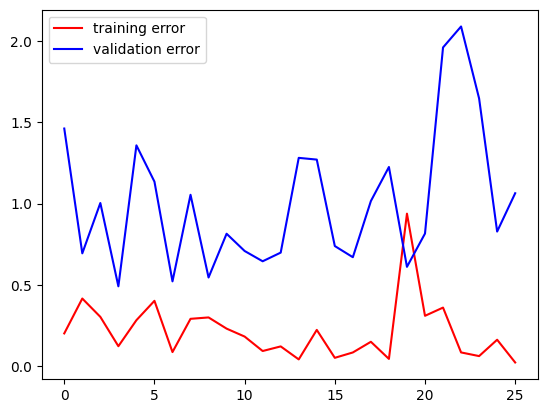

--------------------------------------------
Training = 35.0 %


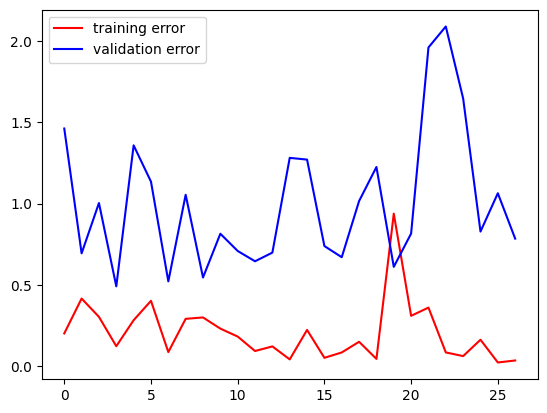

--------------------------------------------
Training = 40.0 %


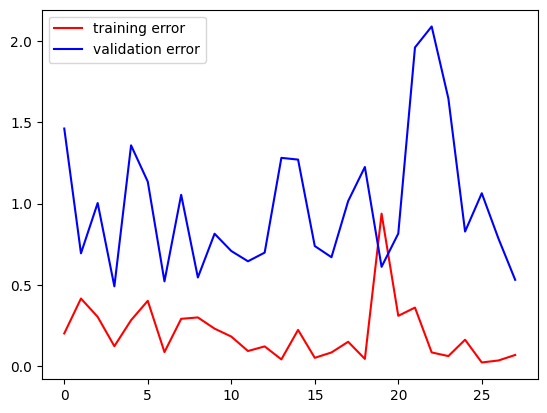

--------------------------------------------
Training = 45.0 %


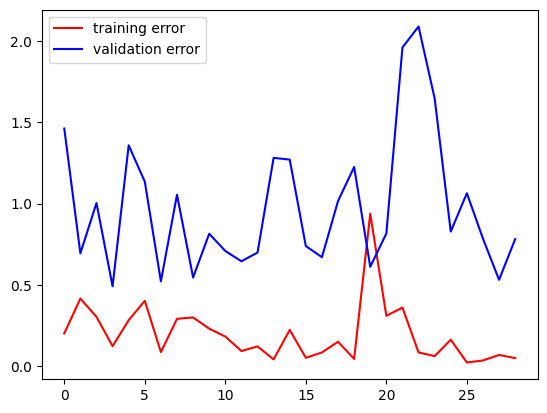

--------------------------------------------
Training = 50.0 %


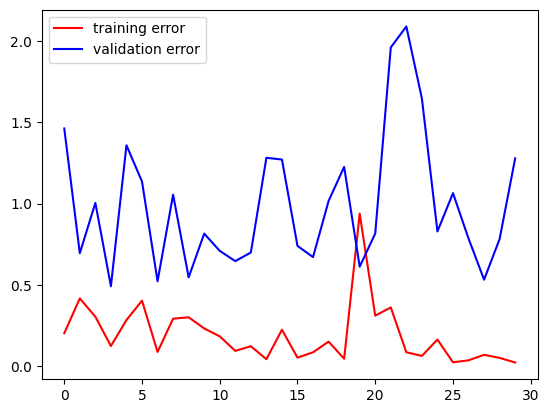

--------------------------------------------
Training = 55.0 %


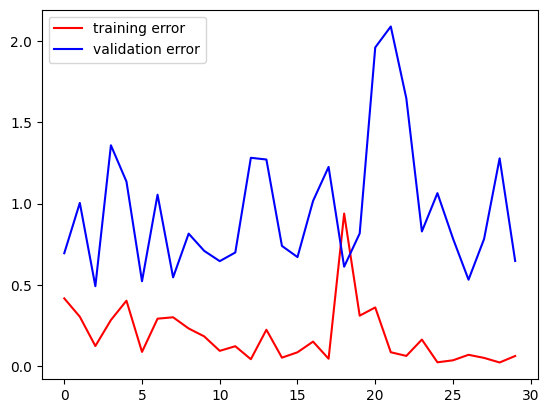

--------------------------------------------
Training = 60.0 %


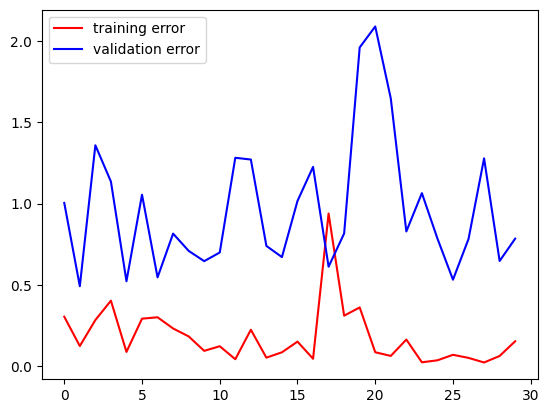

--------------------------------------------
Training = 65.0 %


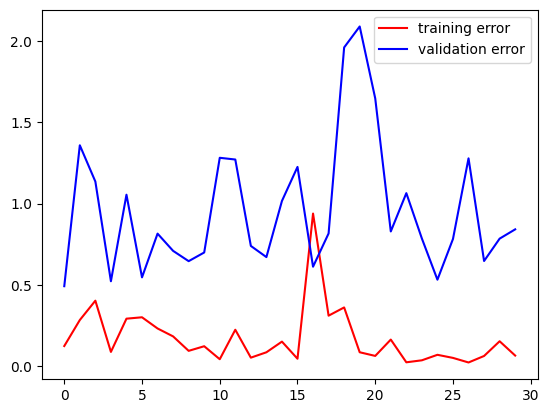

--------------------------------------------
Training = 70.0 %


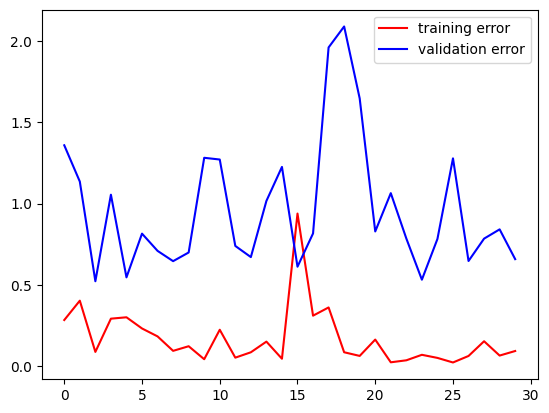

--------------------------------------------
Training = 75.0 %


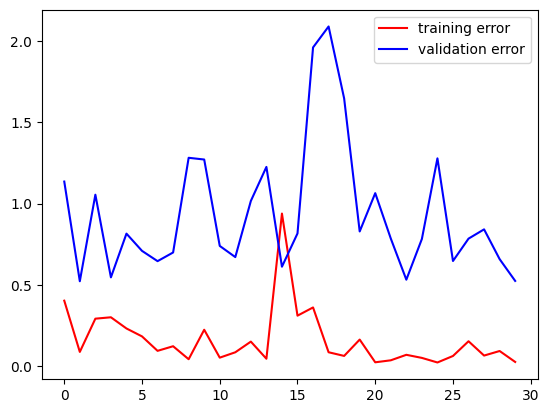

--------------------------------------------
Training = 80.0 %


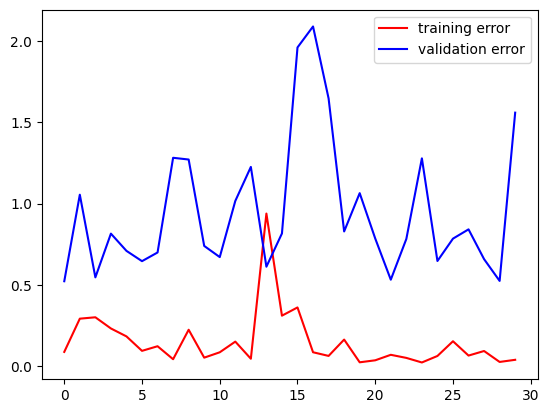

--------------------------------------------
Training = 85.0 %


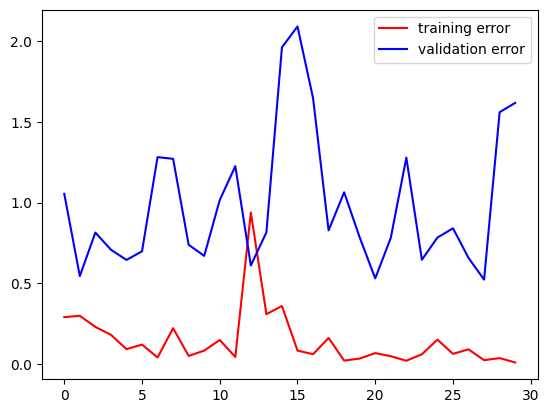

--------------------------------------------
Training = 90.0 %


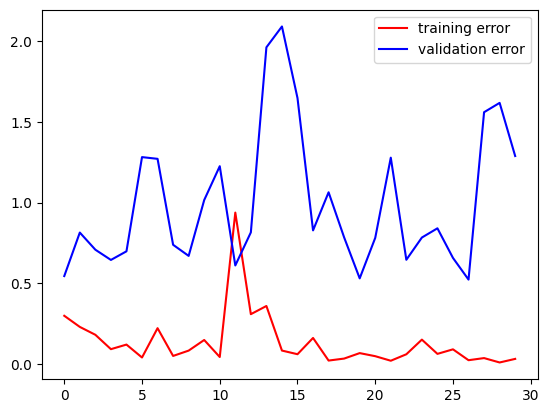

--------------------------------------------
Training = 95.0 %


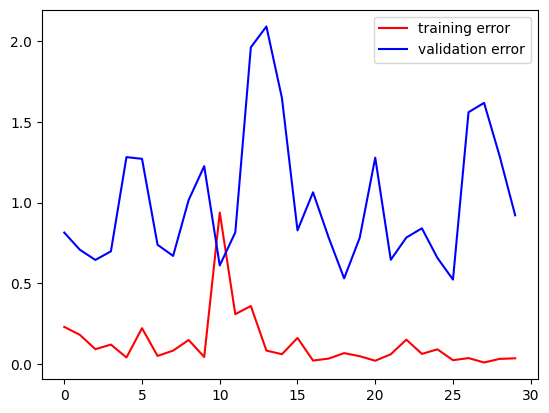

--------------------------------------------
epoch = 1
dim_clique = 32
training error = 0.036116745322942734
validation error = 0.9216486811637878
test error = 0.08517488837242126
--------------------------------------------
Training = 0.0 %


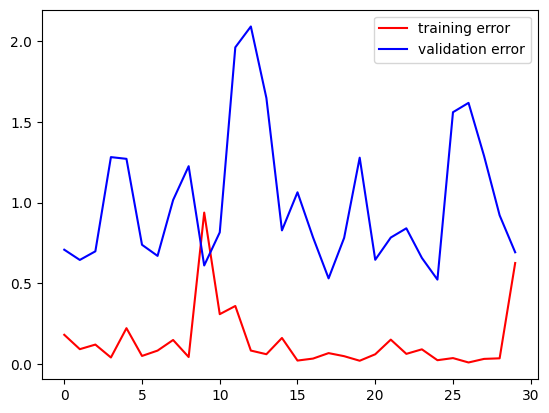

--------------------------------------------
Training = 5.0 %


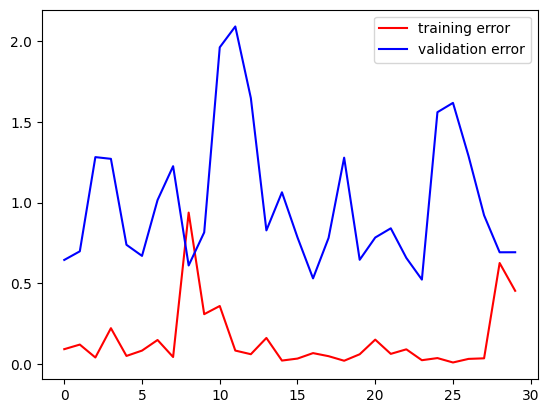

--------------------------------------------
Training = 10.0 %


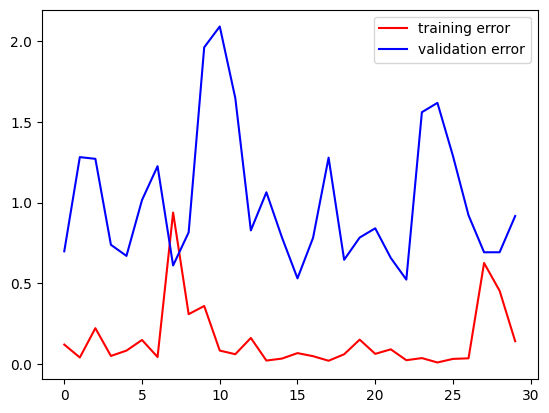

--------------------------------------------
Training = 15.0 %


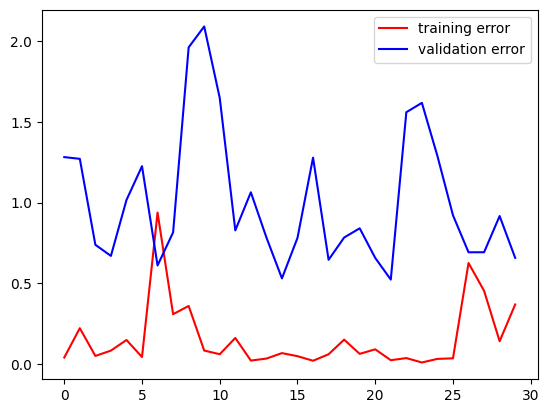

--------------------------------------------
Training = 20.0 %


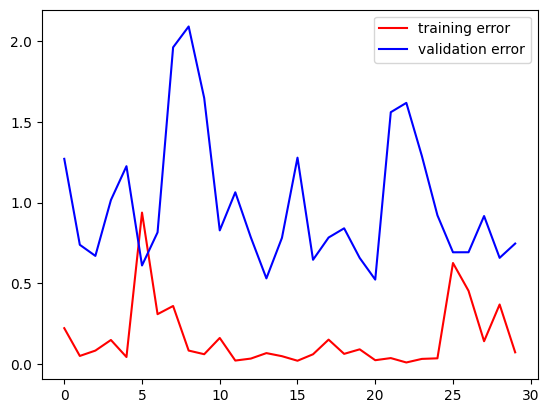

--------------------------------------------
Training = 25.0 %


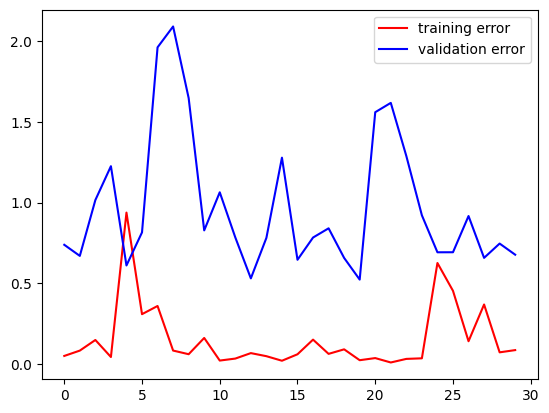

--------------------------------------------
Training = 30.0 %


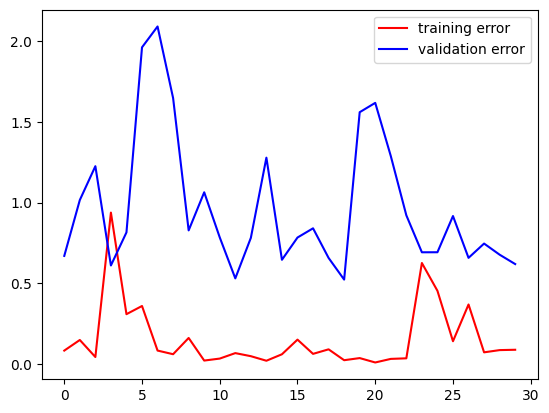

--------------------------------------------
Training = 35.0 %


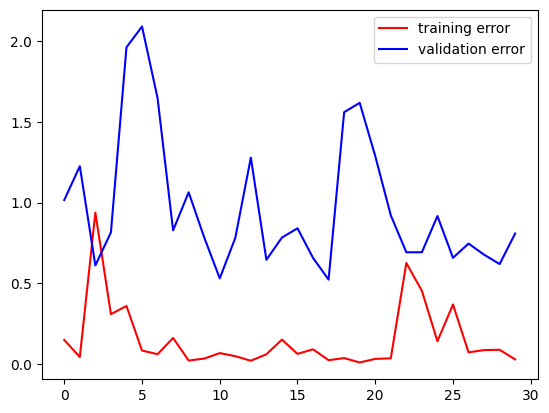

--------------------------------------------
Training = 40.0 %


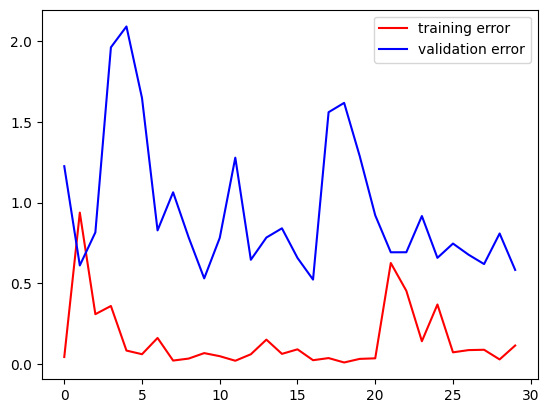

--------------------------------------------
Training = 45.0 %


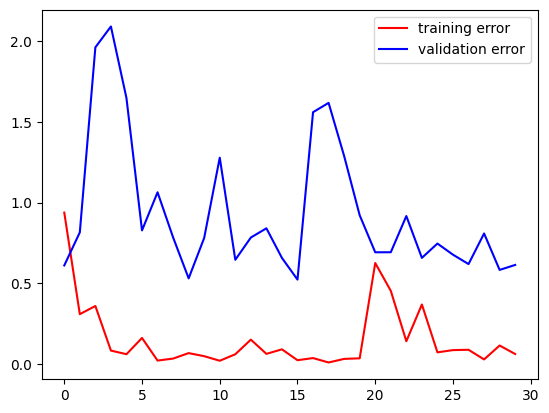

--------------------------------------------
Training = 50.0 %


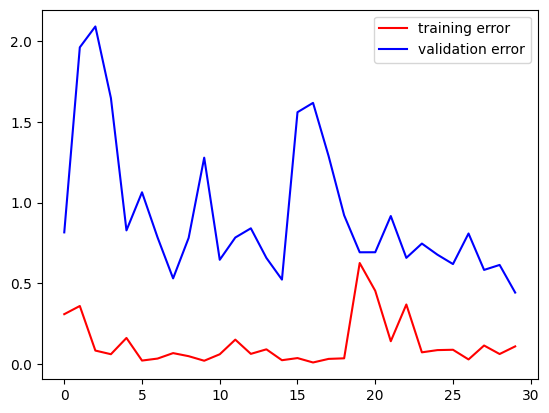

--------------------------------------------
Training = 55.0 %


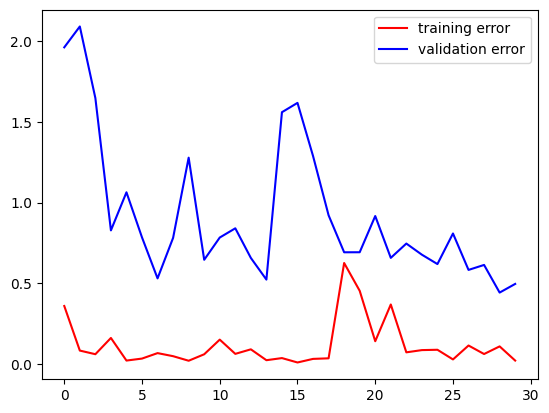

--------------------------------------------
Training = 60.0 %
epoch = 2
dim_clique = 32
training error = 0.15938881039619446
validation error = 0.08402632921934128
test error = 0.2455388605594635
--------------------------------------------
Early stop
--------------------------------------------


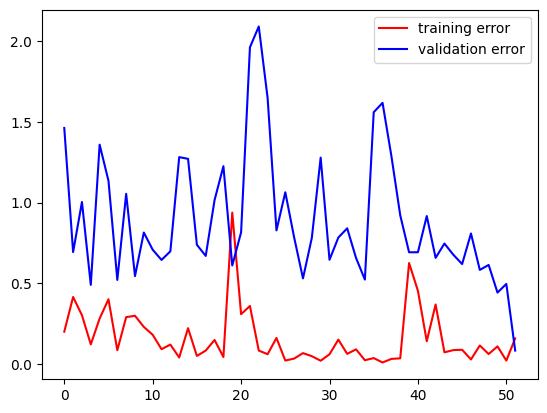

k/n = [5.0, 4.8, 4.6, 4.4, 4.2, 4.0, 3.8, 3.6, 3.4, 3.2] % = [100.0, 100.0, 100.0, 100.0, 65.0, 90.0, 90.0, 95.0, 90.0, 90.0]
Training = 0.0 %


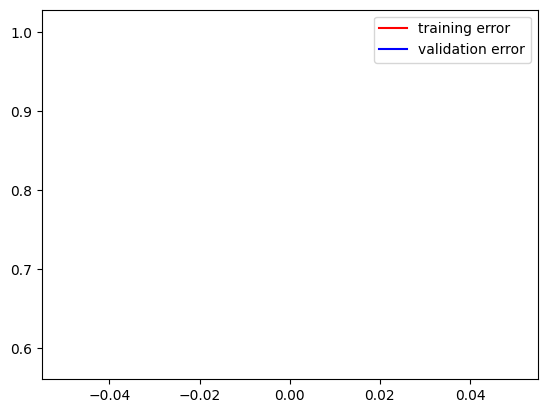

--------------------------------------------
Training = 5.0 %


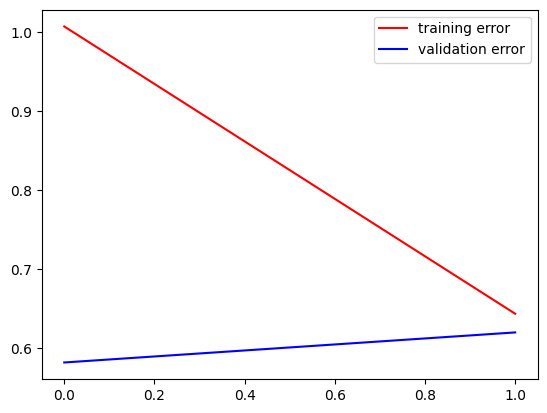

--------------------------------------------
Training = 10.0 %


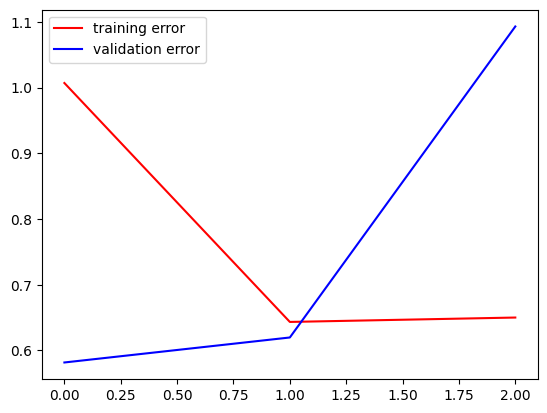

--------------------------------------------
Training = 15.0 %


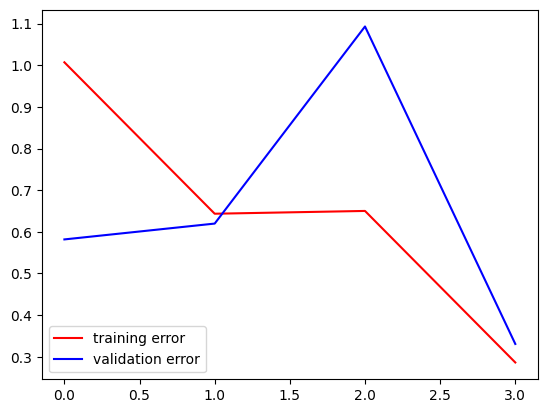

--------------------------------------------
Training = 20.0 %


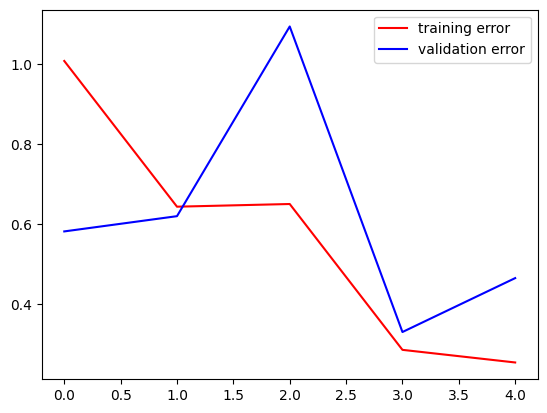

--------------------------------------------
Training = 25.0 %


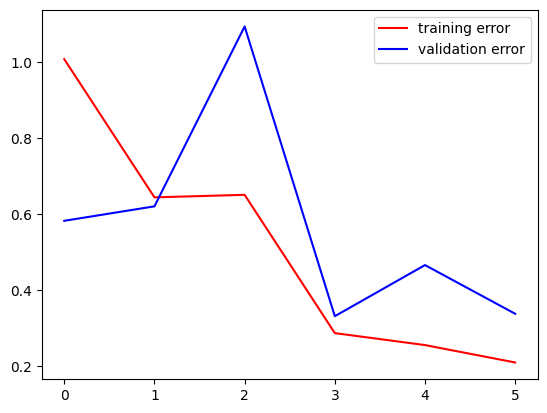

--------------------------------------------
Training = 30.0 %


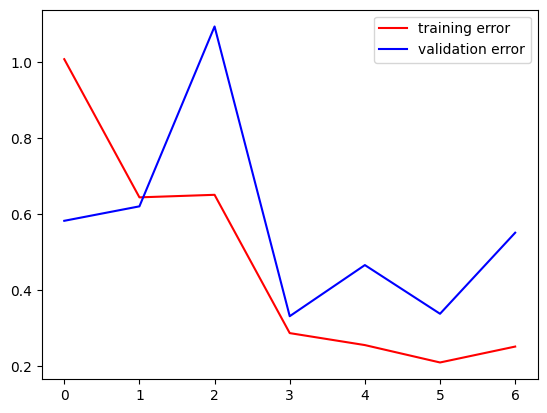

--------------------------------------------
Training = 35.0 %


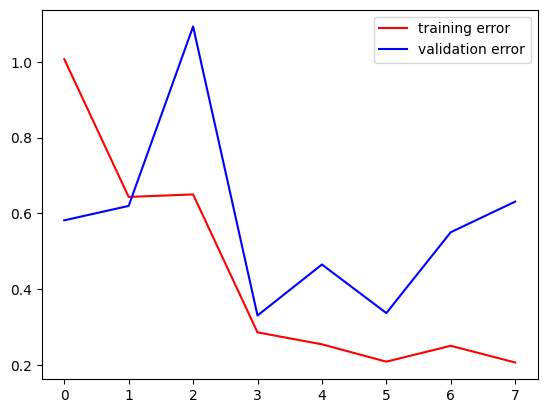

--------------------------------------------
Training = 40.0 %


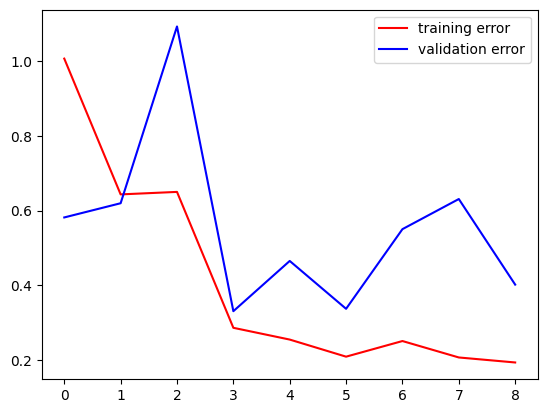

--------------------------------------------
Training = 45.0 %


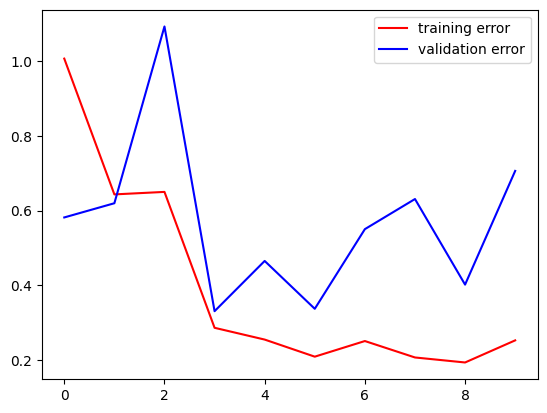

--------------------------------------------
Training = 50.0 %


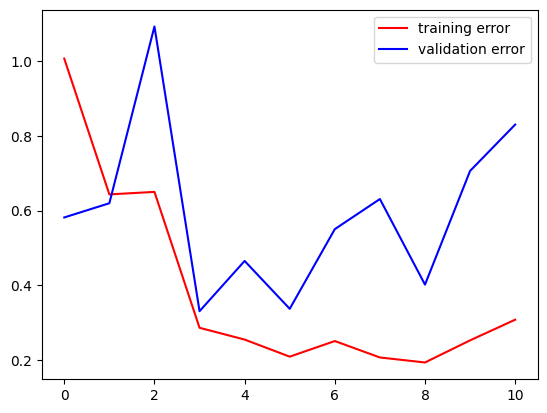

--------------------------------------------
Training = 55.0 %
epoch = 0
dim_clique = 30
training error = 0.14876914024353027
validation error = 0.4481654763221741
test error = 0.4581606388092041
--------------------------------------------
Training = 0.0 %


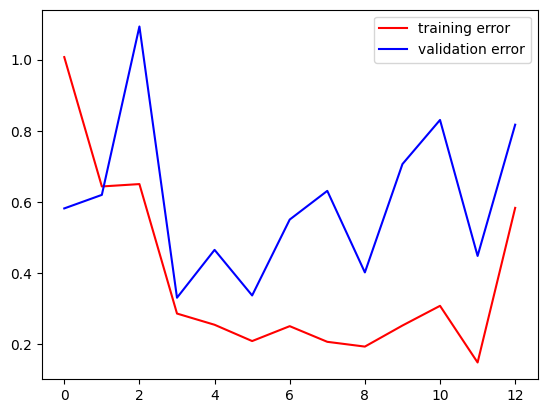

--------------------------------------------
Training = 5.0 %


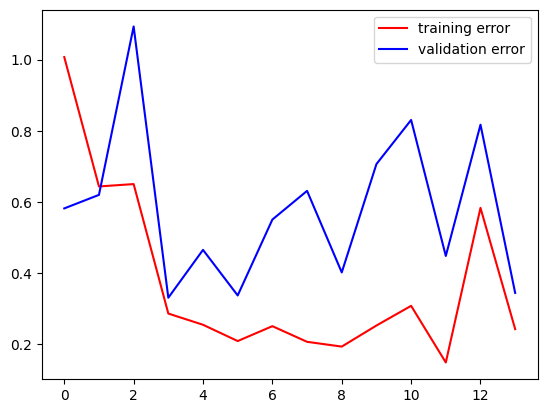

--------------------------------------------
Training = 10.0 %


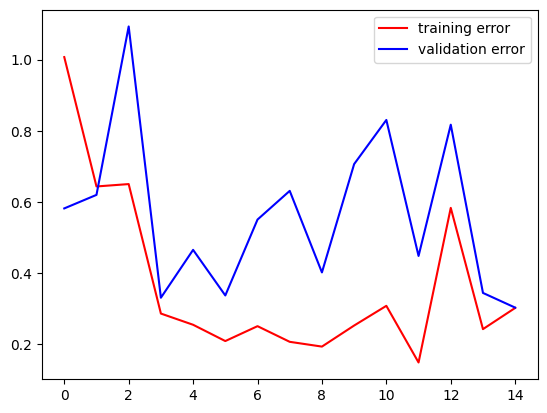

--------------------------------------------
Training = 15.0 %


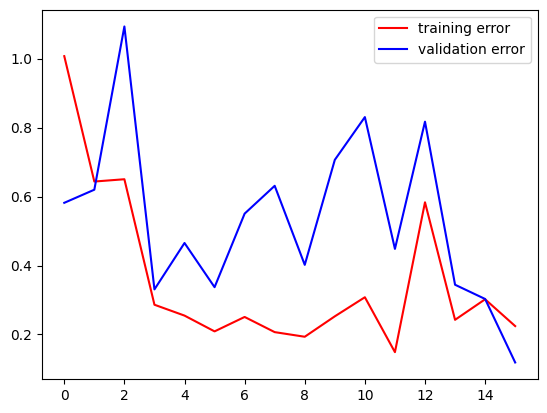

--------------------------------------------
Training = 20.0 %


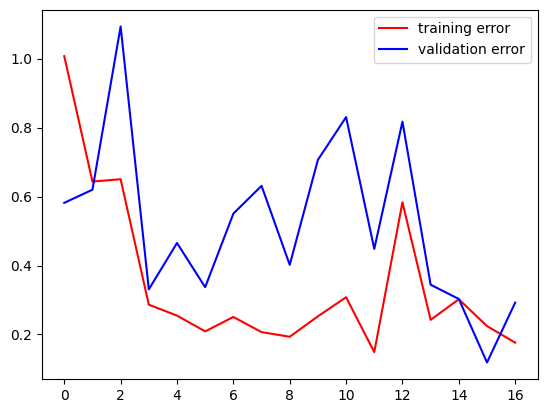

--------------------------------------------
Training = 25.0 %


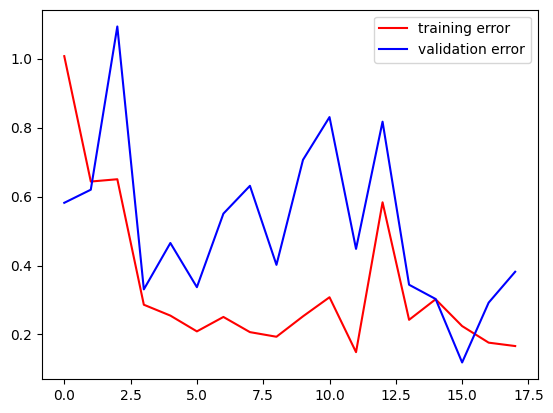

--------------------------------------------
Training = 30.0 %


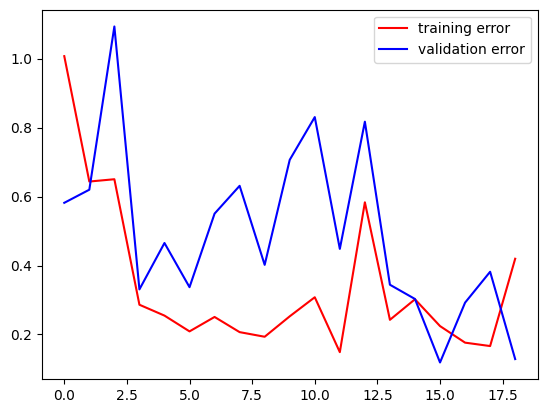

--------------------------------------------
Training = 35.0 %


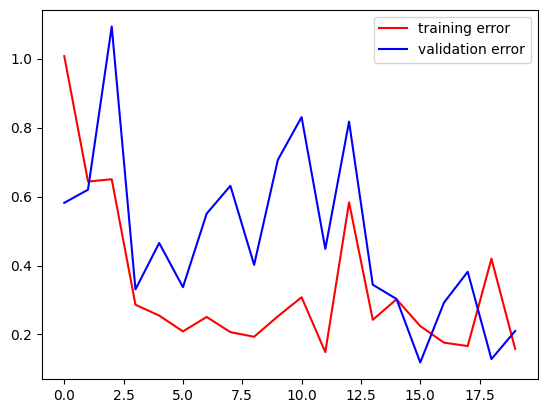

--------------------------------------------
Training = 40.0 %


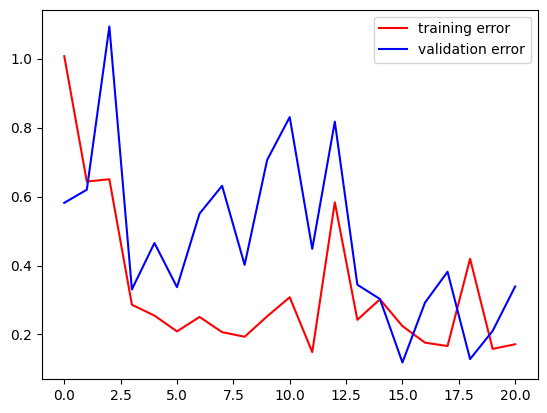

--------------------------------------------
Training = 45.0 %


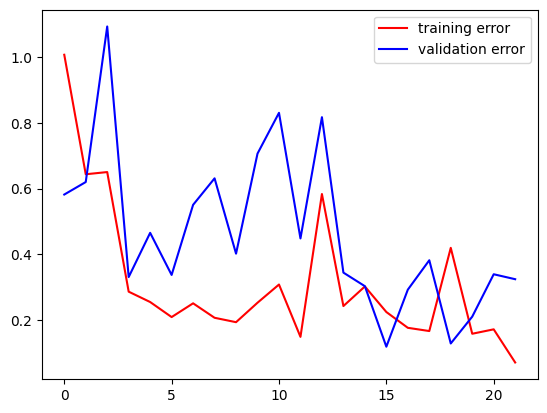

--------------------------------------------
Training = 50.0 %


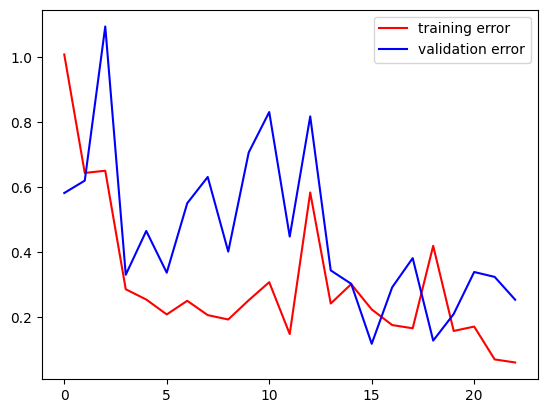

--------------------------------------------
Training = 55.0 %


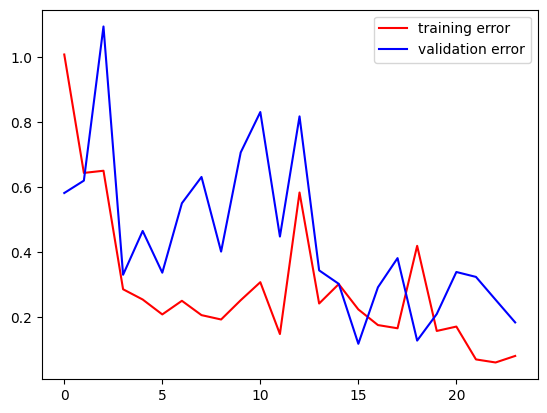

--------------------------------------------
Training = 60.0 %


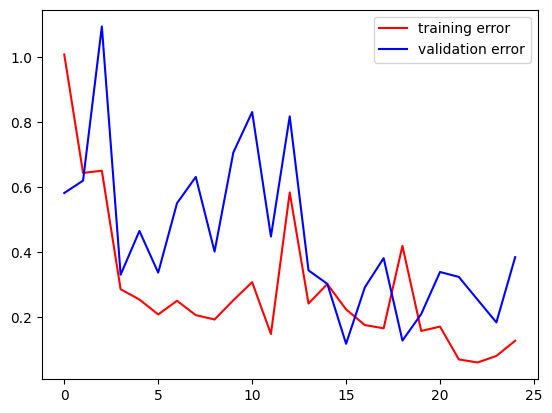

--------------------------------------------
Training = 65.0 %
epoch = 1
dim_clique = 30
training error = 0.13272154331207275
validation error = 0.08589340001344681
test error = 0.2949540317058563
--------------------------------------------
Early stop
--------------------------------------------


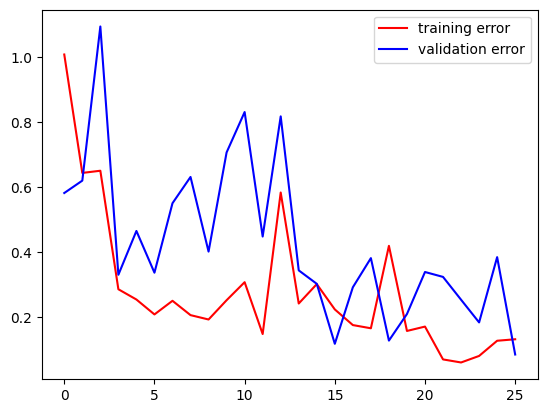

k/n = [5.0, 4.8, 4.6, 4.4, 4.2, 4.0, 3.8, 3.6, 3.4, 3.2, 3.0] % = [100.0, 100.0, 100.0, 100.0, 65.0, 90.0, 90.0, 95.0, 90.0, 90.0, 90.0]


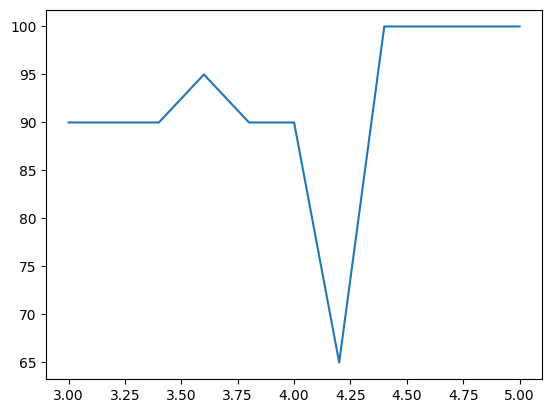

In [ ]:
epoch=5                   # number of epochs
max_steps=100             # maximum number of steps for each epoch
num_train=20              # dimension of the training set at each epoch
num_val=20                # dimension of the validation set
num_test=20               # dimension of the test set
dim_graph=100             # number of nodes
start_dim_clique=50       # dimension of the clique to start with
jump=2                    # jump lengths for the first loop
save_step=5               # number of steps after which we check the early stopping criterion
stop = 29                     # clique size at which we stop
training_exit_error = 0.2    # training error below which we can stop early
validation_exit_error = 0.1  # validation error below which we can stop early

train_error=[]
val_error=[]

generalization=[]
k_over_n=[]
for m in range(0,start_dim_clique-stop,jump):
  dim_clique = start_dim_clique - m
  test = GetClique(num_test,dim_graph,dim_clique, prob = 0.5)
  k_over_n.append(1.0*dim_clique/math.sqrt(dim_graph))
  loss=1.0
  count=0

  for j in range(epoch):
    early_stop_counter=0
    min_validation_loss = np.inf
    train = GetClique(num_train,dim_graph,dim_clique, prob = 0.5)
    val = GetClique(num_val,dim_graph,dim_clique, prob = 0.5)
    for i in range(max_steps):
      output = model(train[0].to(device))
      loss=criterion(output.type(torch.float).to(device), torch.Tensor(train[1]).type(torch.long).to(device))

      # every "print_step" steps we save the error of the train and validation set
      if (i%save_step == 0):
        print('Training =',100.0*i/max_steps,'%')
        train_error.append(loss.item())
        check = model(val[0].to(device))   # checks the output on the validation set
        val_loss = criterion(check.to(device), torch.Tensor(val[1]).type(torch.long).to(device)).item()
        val_error.append(val_loss)

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_exit,min_validation_loss,early_stop_counter = EarlyStopper(np.array(val_error), early_stop_counter, min_validation_loss)
        if (val_error[count]<validation_exit_error or (early_exit and train_error[count]<training_exit_error)):
          count=count+1
          break

        count=count+1
        if (count > 30):
          # plot of test and validation error curves
          x_axis = np.arange(30)
          fig, ax = plt.subplots()
          ax.plot(x_axis, train_error[count-30:count], 'r', label='training error')
          ax.plot(x_axis, val_error[count-30:count], 'b', label='validation error')
          ax.legend()
          plt.show()
          print('--------------------------------------------')
        else:
          # plot of test and validation error curves
          x_axis = np.arange(count)
          fig, ax = plt.subplots()
          ax.plot(x_axis, train_error[:count], 'r', label='training error')
          ax.plot(x_axis, val_error[:count], 'b', label='validation error')
          ax.legend()
          plt.show()
          print('--------------------------------------------')

      loss.backward()
      optim.step()
      optim.zero_grad(set_to_none=True)


    # test error
    test_output = model(test[0].to(device))   # checks the output on the test set
    test_error = criterion(test_output.to(device), torch.Tensor(test[1]).type(torch.long).to(device))
    if (j%1 == 0):
      print('epoch =',j)
      print('dim_clique =',dim_clique)
      print('training error =', train_error[count-1])
      print('validation error =',val_error[count-1])
      print('test error =',test_error.item())
      print('--------------------------------------------')

    if (val_error[count-1]<validation_exit_error):
          print('Early stop')
          print('--------------------------------------------')
          break
  # plot of test and validation error curves
  x_axis = np.arange(count)
  fig, ax = plt.subplots()
  ax.plot(x_axis, train_error[:count], 'r', label='training error')
  ax.plot(x_axis, val_error[:count], 'b', label='validation error')
  ax.legend()
  plt.show()

  train_error=[]
  val_error=[]

  data = test
  hard_output = torch.zeros([num_test,2])

  soft_output = model(data[0].to(device))
  for l in range(num_test):
    if (soft_output[l][0] > soft_output[l][1]):
      hard_output[l][0] = 1.0
    else: hard_output[l][1] = 1.0
  predicted_output = hard_output

  generalization.append(100*(1-torch.sum(torch.square(torch.Tensor(data[1])-torch.transpose(predicted_output,1,0)[1])).item()/(1.0*num_test)))
  print('k/n =', k_over_n, '% =', generalization)
  print('==========================================')

plt.plot(k_over_n,generalization)

Here we check the generalization error and we compute the transition at which the CNN strats to fail.

k = 85 ----> % = 99.33333333333333
k = 84 ----> % = 98.33333333333333
k = 83 ----> % = 99.66666666666667
k = 82 ----> % = 99.33333333333333
k = 81 ----> % = 99.66666666666667
k = 80 ----> % = 100.0
k = 79 ----> % = 100.0
k = 78 ----> % = 99.66666666666667
k = 77 ----> % = 100.0
k = 76 ----> % = 99.33333333333333
k = 75 ----> % = 99.66666666666667
k = 74 ----> % = 99.33333333333333
k = 73 ----> % = 99.66666666666667
k = 72 ----> % = 100.0
k = 71 ----> % = 99.66666666666667
k = 70 ----> % = 99.66666666666667
k = 69 ----> % = 100.0
k = 68 ----> % = 100.0
k = 67 ----> % = 100.0
k = 66 ----> % = 99.33333333333333
k = 65 ----> % = 99.33333333333333
k = 64 ----> % = 99.0
k = 63 ----> % = 100.0
k = 62 ----> % = 100.0
k = 61 ----> % = 100.0
k = 60 ----> % = 99.66666666666667
k = 59 ----> % = 99.66666666666667
k = 58 ----> % = 99.66666666666667
k = 57 ----> % = 98.66666666666667
k = 56 ----> % = 99.66666666666667
k = 55 ----> % = 99.66666666666667
k = 54 ----> % = 100.0
k = 53 ----> % = 100.0
k 

k = 3 ----> % = 51.333333333333336
k over sqrt(n) = [8.5, 8.4, 8.3, 8.2, 8.1, 8.0, 7.9, 7.8, 7.7, 7.6, 7.5, 7.4, 7.3, 7.2, 7.1, 7.0, 6.9, 6.8, 6.7, 6.6, 6.5, 6.4, 6.3, 6.2, 6.1, 6.0, 5.9, 5.8, 5.7, 5.6, 5.5, 5.4, 5.3, 5.2, 5.1, 5.0, 4.9, 4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2, 4.1, 4.0, 3.9, 3.8, 3.7, 3.6, 3.5, 3.4, 3.3, 3.2, 3.1, 3.0, 2.9, 2.8, 2.7, 2.6, 2.5, 2.4, 2.3, 2.2, 2.1, 2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3] % = [99.33333333333333, 98.33333333333333, 99.66666666666667, 99.33333333333333, 99.66666666666667, 100.0, 100.0, 99.66666666666667, 100.0, 99.33333333333333, 99.66666666666667, 99.33333333333333, 99.66666666666667, 100.0, 99.66666666666667, 99.66666666666667, 100.0, 100.0, 100.0, 99.33333333333333, 99.33333333333333, 99.0, 100.0, 100.0, 100.0, 99.66666666666667, 99.66666666666667, 99.66666666666667, 98.66666666666667, 99.66666666666667, 99.66666666666667, 100.0, 100.0, 99.33333333333333, 98.66666666666667, 99.33333333333333, 

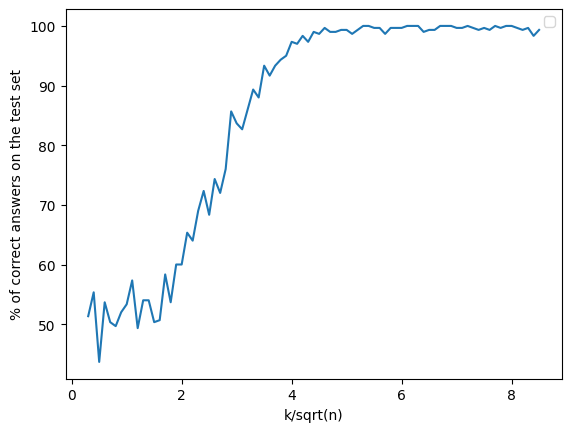

In [ ]:
start_dim_clique = 85
times = 15

generalization_CNN = []
k_vs_sqrt_n_CNN = []

for m in range(0,start_dim_clique-2,1):
  dim_clique = start_dim_clique - m
  k_vs_sqrt_n_CNN.append(1.0*dim_clique/math.sqrt(dim_graph))
  mean = 0

  for j in range(times):
    data = GetClique(num_train,dim_graph,dim_clique, prob = 0.5)
    hard_output = torch.zeros([num_test,2])

    soft_output = model(data[0].to(device))
    for l in range(num_test):
      if (soft_output[l][0] > soft_output[l][1]):
        hard_output[l][0] = 1.0
      else: hard_output[l][1] = 1.0
    predicted_output = hard_output

    mean = mean + 100*(1-torch.sum(torch.square(torch.Tensor(data[1])-torch.transpose(predicted_output,1,0)[1])).item()/(1.0*num_test))

  mean = mean/times
  generalization_CNN.append(mean)
  print('k =',dim_clique,'---->', '% =', mean)
  print('==========================================')
print('k over sqrt(n) =', list(k_vs_sqrt_n_CNN), '% =', list(generalization_CNN))
print('==========================================')

fig, ax = plt.subplots()
ax.plot(k_vs_sqrt_n_CNN,generalization_CNN)
plt.xlabel('k/sqrt(n)')
plt.ylabel('% of correct answers on the test set')
ax.legend()
plt.show()

# Graph Neural Networks (GNNs)

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 55.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


We build a different dataset generator in the case of GNNs. In fact out graph nodes have no labels, which is not in line with standard GNN architectures. Therefore we have to choose to assign features based on (?). These features some connectivity properties of each node.

In [ ]:
def Plant(A,k,n):
  A[:k,:k] = torch.ones(k,k)
  r = torch.randperm(n)
  A = A[r[:, None], r]
  return A

def PlantedClique(n,p,k,on_off,hidden):
  if (on_off == 0):
    if (hidden == 1):
      p_off = p + (1-p)*(k*(k-1))/(n*(n-1))
    else:
      p_off = p
    A = torch.bernoulli(p_off*torch.ones(n,n))
    A_up = torch.triu(A)
    A = A_up + torch.transpose(A_up, 0, 1)
    A.fill_diagonal_(0)
    return A,on_off
  if (on_off == 1):
    p_on = p
    B = torch.bernoulli(p_on*torch.ones(n,n))
    B_up = torch.triu(B)
    B = B_up + torch.transpose(B_up, 0, 1)
    B.fill_diagonal_(1)
    C = Plant(B,k,n).fill_diagonal_(0)
    return C,on_off

def GetClique(m,n,k,p=0.5,prob=0.5,hidden = 1):
  on_off = torch.bernoulli(prob*torch.ones(m))
  attrib = torch.rand((n*m,5))
  for i in range(m):
    if (i==0):
      data_0 = PlantedClique(n,p,k,on_off[i],hidden)[0]
      batch = i*torch.ones(n)
    else:
      x = PlantedClique(n,p,k,on_off[i],hidden)[0]
      data_0 = torch.block_diag(data_0, x)
      batch = torch.cat((batch, i*torch.ones(n)), 0)

  v_1=torch.sum(data_0,dim=1)
  copy_v_1 = v_1.repeat(n*m,1)
  v_2=torch.sum(copy_v_1*data_0,dim=1)/v_1
  copy_v_2 = v_1.repeat(n*m,1)-v_2.repeat(n*m,1).t()
  copy_v_2 = copy_v_2*copy_v_2
  v_3=torch.sqrt(torch.sum(copy_v_2*data_0,dim=1)/v_1)
  v_4,v_4_ind=torch.max(copy_v_1*data_0,dim=1)
  v_5_contra,v_5_ind=torch.max(data_0/(copy_v_1),dim=1)
  v_5 = 1/v_5_contra

  attrib[:,0] = v_1
  attrib[:,1] = v_2
  attrib[:,2] = v_3
  attrib[:,3] = v_4
  attrib[:,4] = v_5

  data = data_0.long().nonzero().t().contiguous()
  batch = batch.long()
  return attrib,data,batch,on_off.type(torch.long).tolist()

The architecture is just a deep Graph Convolutional network. Also here we use an EarlyStopper function and dropout.

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

#function for the early stopping
def EarlyStopper(validation_loss, counter, min_validation_loss, past=2, patience=2, min_delta=0.02):
        length = validation_loss.shape[0]
        if np.mean(validation_loss[length-past:]) < min_validation_loss and length > past:
            min_validation_loss = np.mean(validation_loss[length-past:])
            counter = 0
        elif np.mean(validation_loss[length-past:]) > (min_validation_loss + min_delta) and length > past:
            counter += 1
            if counter >= patience:
                return True, min_validation_loss, counter
        return False, min_validation_loss, counter


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels_1, hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_channels_5):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(5, hidden_channels_1)
        self.conv2 = GCNConv(hidden_channels_1, hidden_channels_2)
        self.conv3 = GCNConv(hidden_channels_2, hidden_channels_3)
        self.conv4 = GCNConv(hidden_channels_3, hidden_channels_4)
        self.conv5 = GCNConv(hidden_channels_4, hidden_channels_5)
        self.lin = Linear(hidden_channels_5, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)

        return x

model_g = GCN(hidden_channels_1=100, hidden_channels_2=80, hidden_channels_3=60, hidden_channels_4=40, hidden_channels_5=20)
optim=torch.optim.Adam(model_g.parameters())   # optimization by Adam
criterion = nn.CrossEntropyLoss()
model_g.to(device)

GCN(
  (conv1): GCNConv(5, 100)
  (conv2): GCNConv(100, 80)
  (conv3): GCNConv(80, 60)
  (conv4): GCNConv(60, 40)
  (conv5): GCNConv(40, 20)
  (lin): Linear(in_features=20, out_features=2, bias=True)
)

Usual training...

Training = 0.0 %


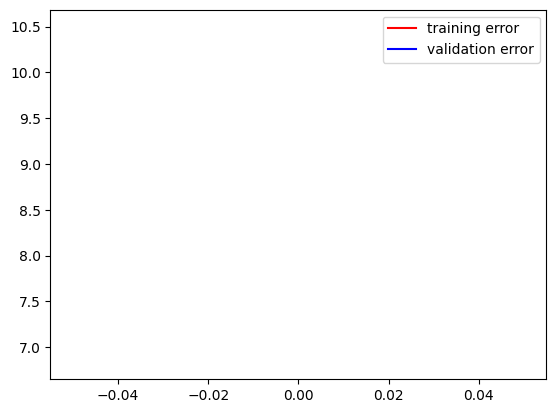

--------------------------------------------
Training = 5.0 %


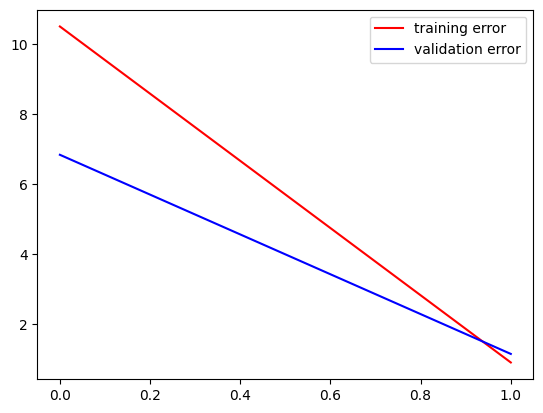

--------------------------------------------
Training = 10.0 %


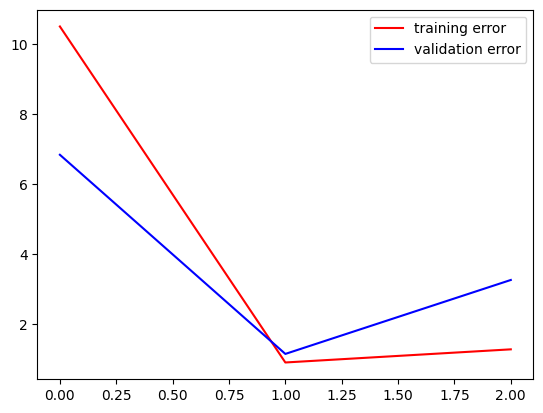

--------------------------------------------
Training = 15.0 %


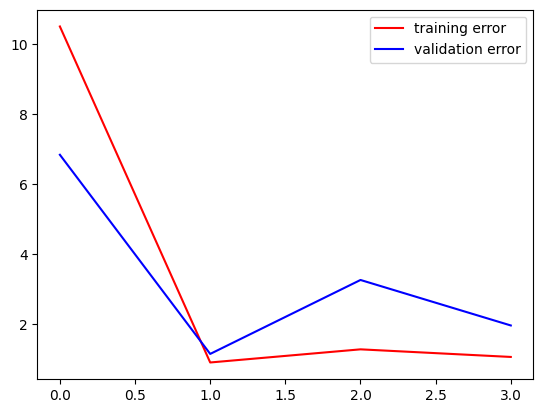

--------------------------------------------
Training = 20.0 %


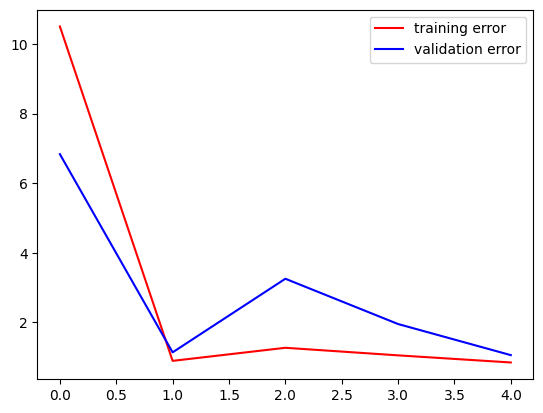

--------------------------------------------
Training = 25.0 %


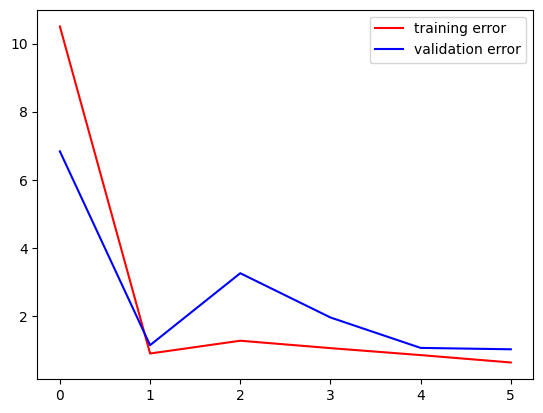

--------------------------------------------
Training = 30.0 %


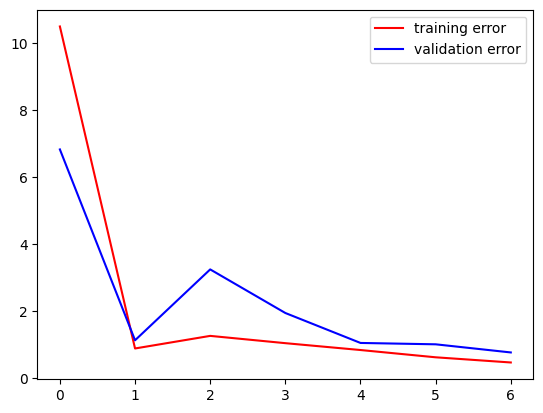

--------------------------------------------
Training = 35.0 %


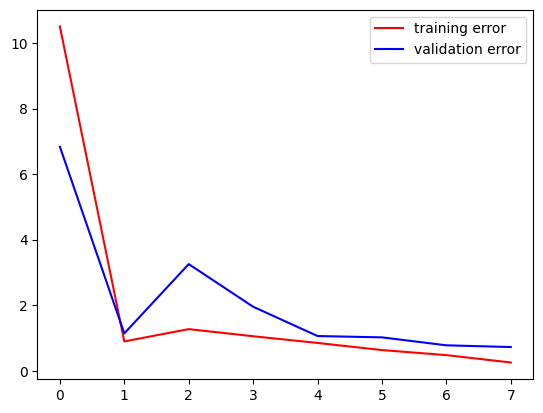

--------------------------------------------
Training = 40.0 %


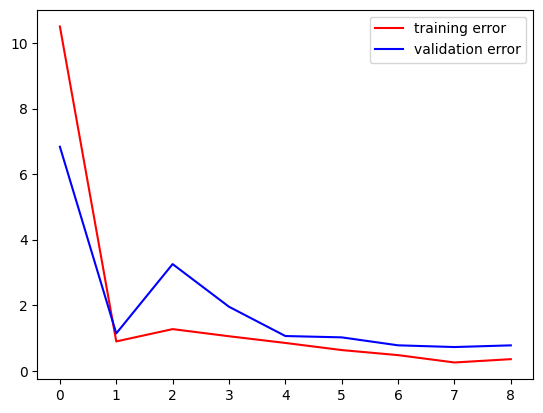

--------------------------------------------
Training = 45.0 %


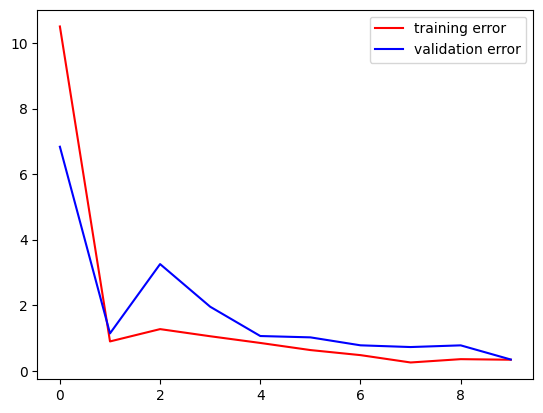

--------------------------------------------
Training = 50.0 %


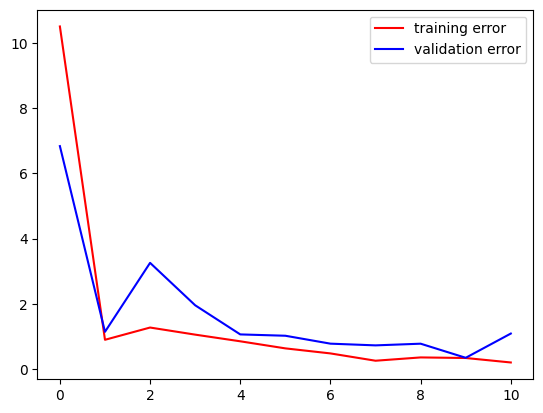

--------------------------------------------
Training = 55.0 %
epoch = 0
dim_clique = 50
training error = 0.1847175657749176
validation error = 0.46634578704833984
test error = 0.5475558042526245
--------------------------------------------
Training = 0.0 %


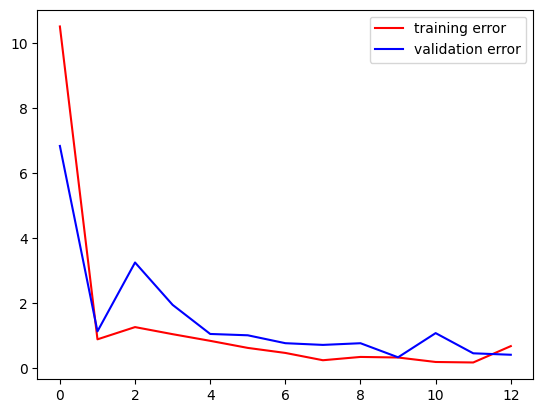

--------------------------------------------
Training = 5.0 %


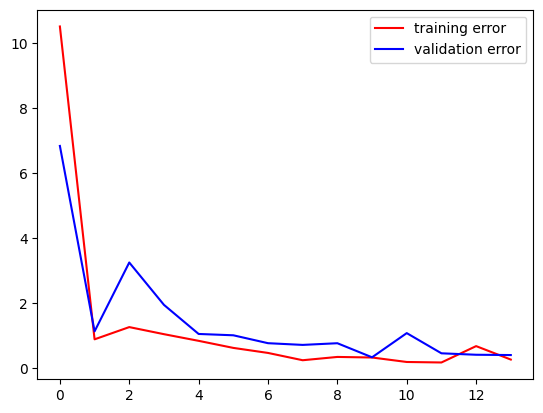

--------------------------------------------
Training = 10.0 %


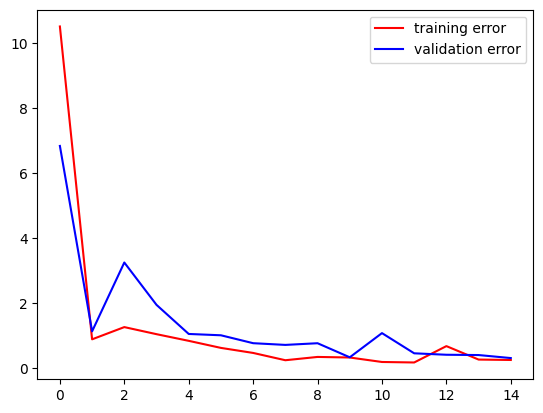

--------------------------------------------
Training = 15.0 %


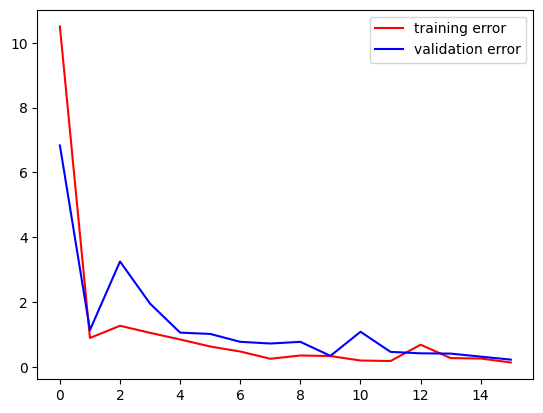

--------------------------------------------
Training = 20.0 %
epoch = 1
dim_clique = 50
training error = 0.2026321142911911
validation error = 0.09484102576971054
test error = 0.08802280575037003
--------------------------------------------
Early stop
--------------------------------------------


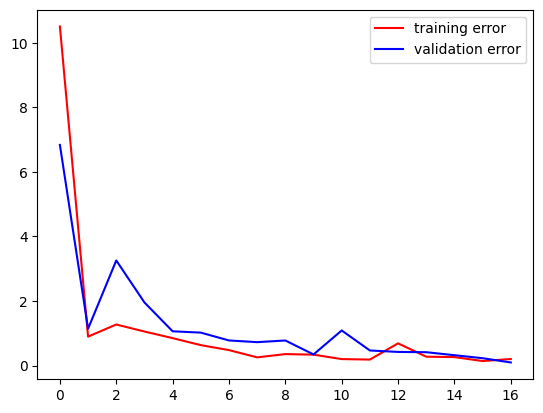

k/n = [5.0] % = [99.5]
Training = 0.0 %


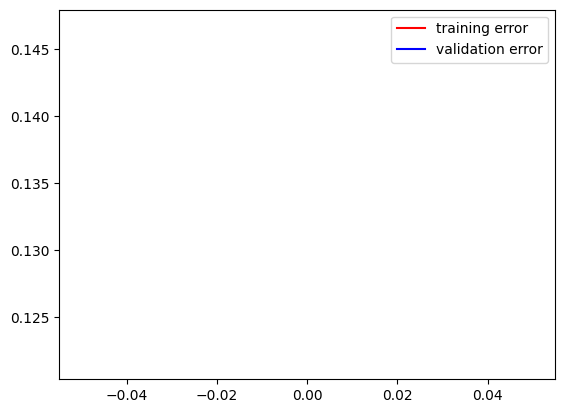

--------------------------------------------
Training = 5.0 %
epoch = 0
dim_clique = 45
training error = 0.10855148732662201
validation error = 0.07716044038534164
test error = 0.18883557617664337
--------------------------------------------
Early stop
--------------------------------------------


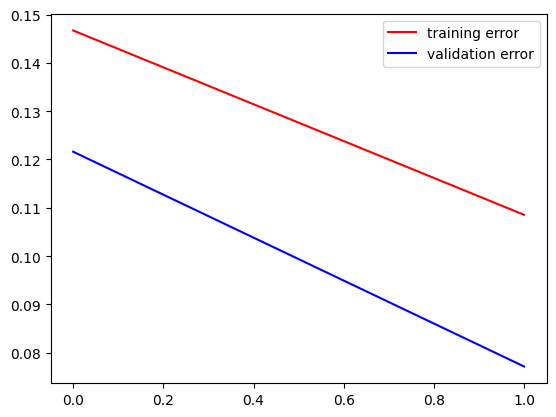

k/n = [5.0, 4.5] % = [99.5, 95.5]
Training = 0.0 %


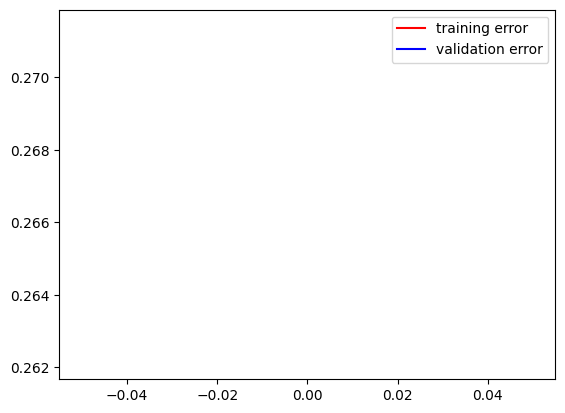

--------------------------------------------
Training = 5.0 %


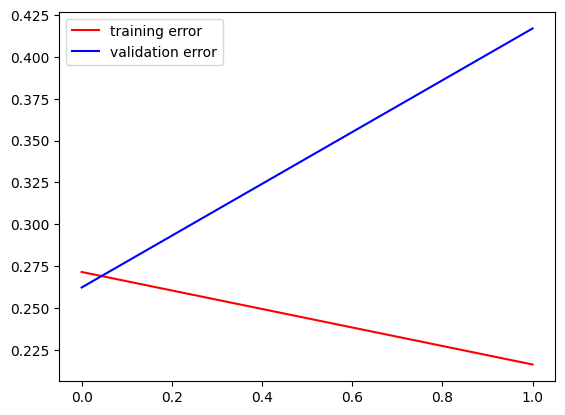

--------------------------------------------
Training = 10.0 %
epoch = 0
dim_clique = 40
training error = 0.12063299119472504
validation error = 0.09205921739339828
test error = 0.10754106193780899
--------------------------------------------
Early stop
--------------------------------------------


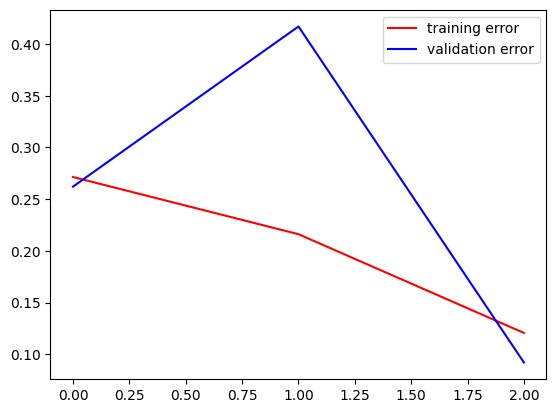

k/n = [5.0, 4.5, 4.0] % = [99.5, 95.5, 99.5]
Training = 0.0 %


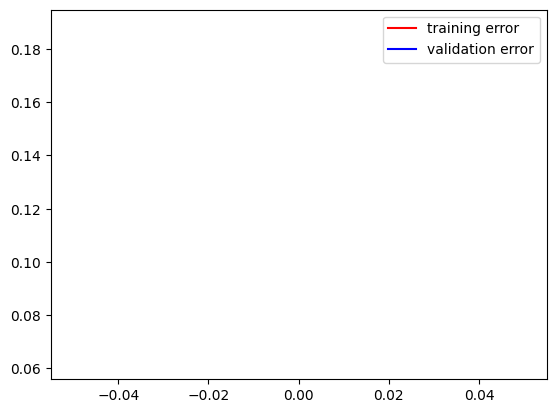

--------------------------------------------
Training = 5.0 %


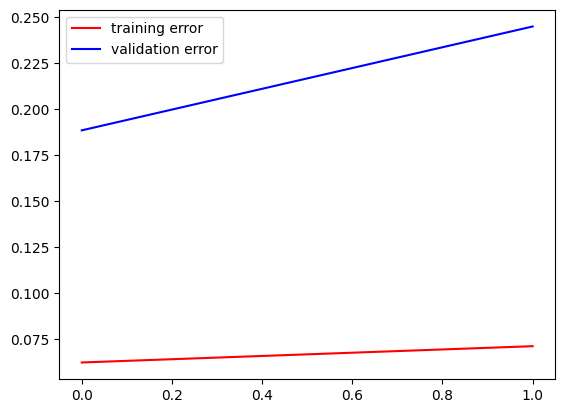

--------------------------------------------
Training = 10.0 %
epoch = 0
dim_clique = 35
training error = 0.036570850759744644
validation error = 0.06945910304784775
test error = 0.10002069175243378
--------------------------------------------
Early stop
--------------------------------------------


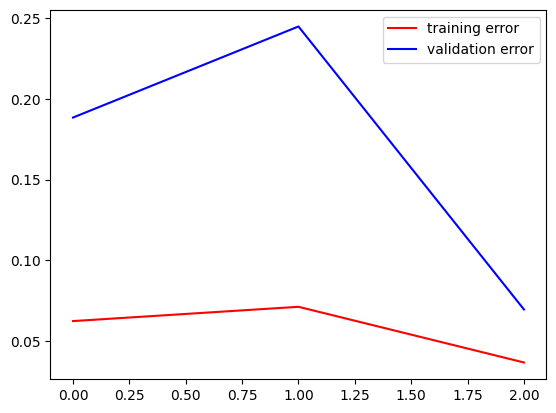

k/n = [5.0, 4.5, 4.0, 3.5] % = [99.5, 95.5, 99.5, 99.0]
Training = 0.0 %


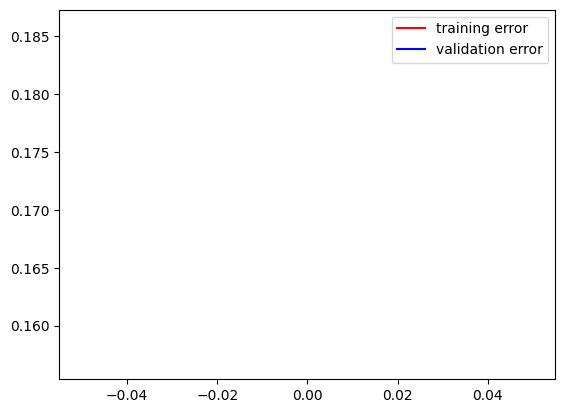

--------------------------------------------
Training = 5.0 %
epoch = 0
dim_clique = 30
training error = 0.1233259066939354
validation error = 0.08435366302728653
test error = 0.1032283678650856
--------------------------------------------
Early stop
--------------------------------------------


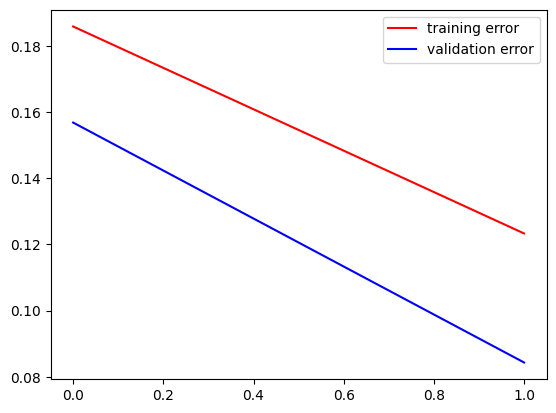

k/n = [5.0, 4.5, 4.0, 3.5, 3.0] % = [99.5, 95.5, 99.5, 99.0, 98.0]
Training = 0.0 %


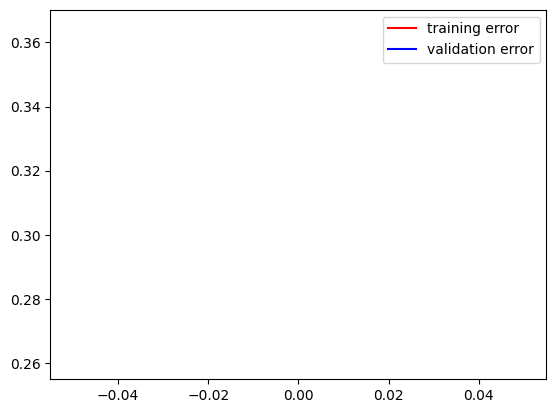

--------------------------------------------
Training = 5.0 %


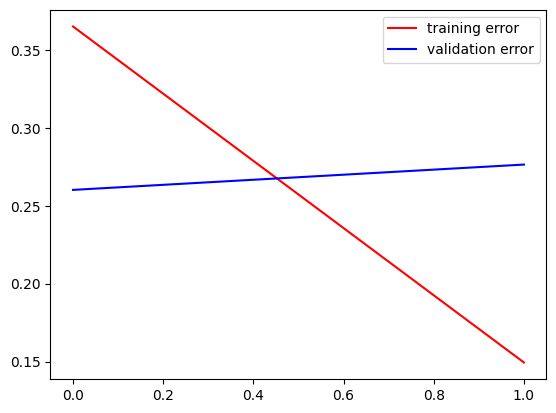

--------------------------------------------
Training = 10.0 %


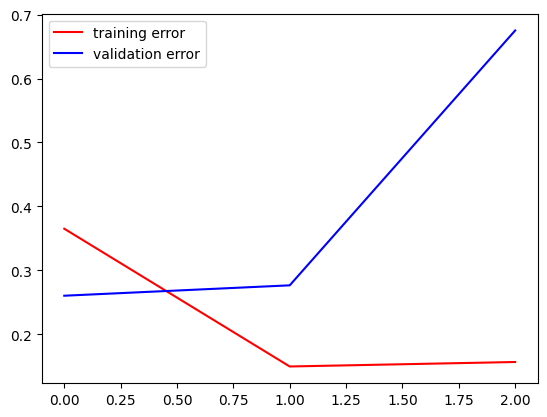

--------------------------------------------
Training = 15.0 %


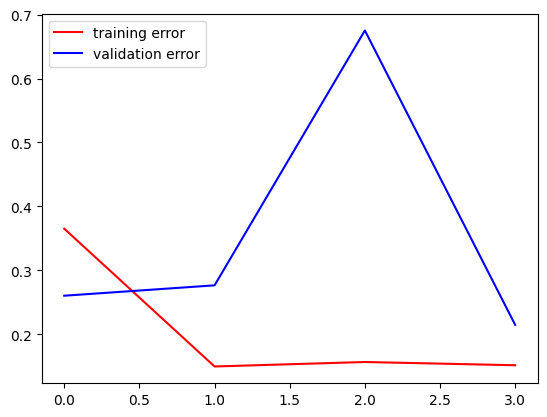

--------------------------------------------
Training = 20.0 %


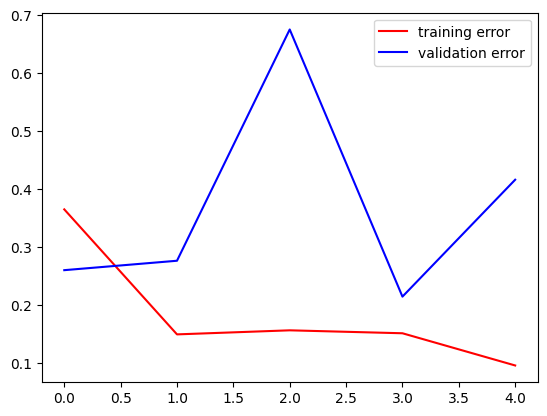

--------------------------------------------
Training = 25.0 %


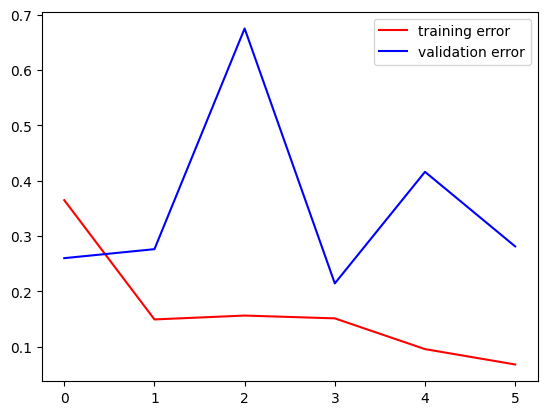

--------------------------------------------
Training = 30.0 %


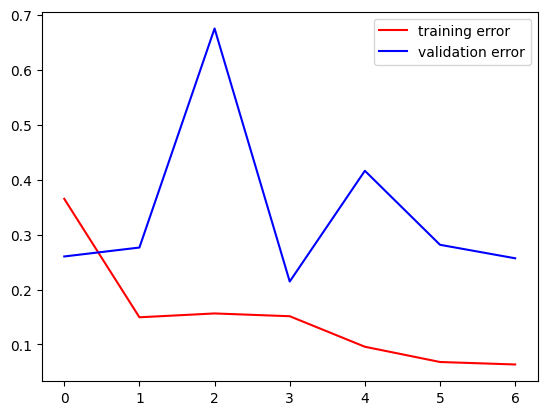

--------------------------------------------
Training = 35.0 %


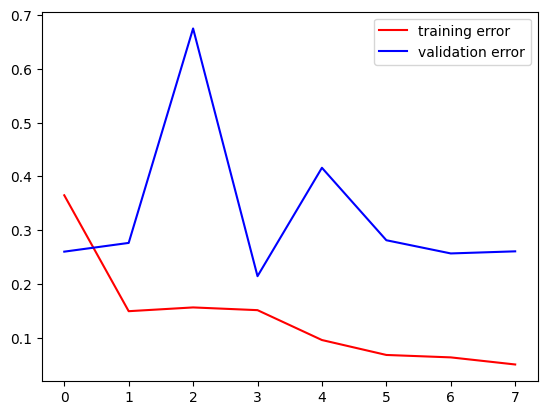

--------------------------------------------
Training = 40.0 %


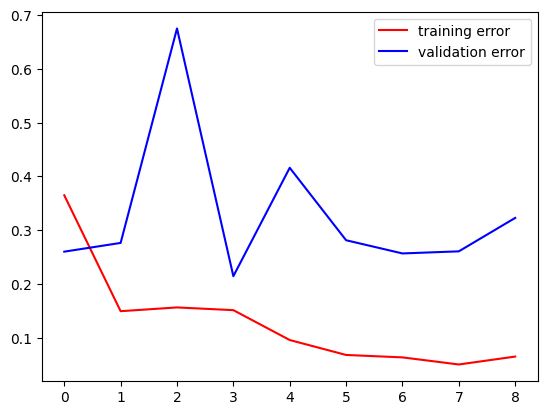

--------------------------------------------
Training = 45.0 %
epoch = 0
dim_clique = 25
training error = 0.029134605079889297
validation error = 0.3599596619606018
test error = 0.210947185754776
--------------------------------------------
Training = 0.0 %


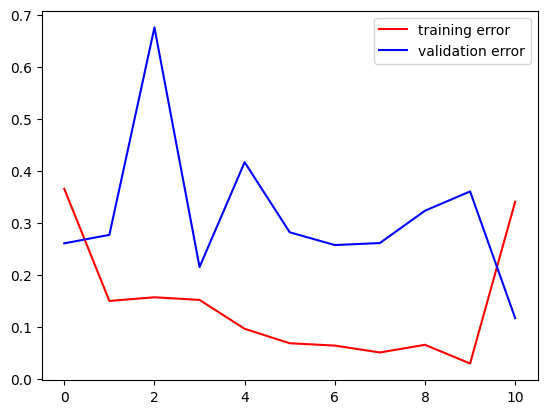

--------------------------------------------
Training = 5.0 %
epoch = 1
dim_clique = 25
training error = 0.19250163435935974
validation error = 0.05906631797552109
test error = 0.09789155423641205
--------------------------------------------
Early stop
--------------------------------------------


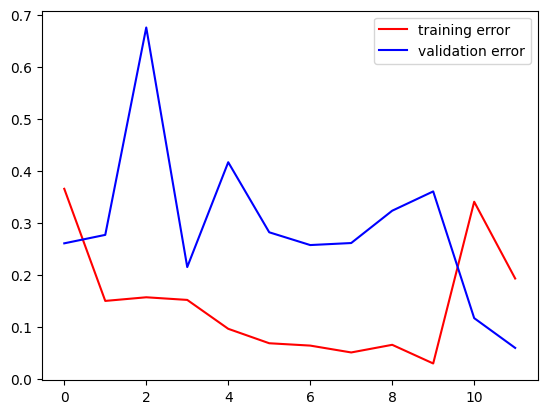

k/n = [5.0, 4.5, 4.0, 3.5, 3.0, 2.5] % = [99.5, 95.5, 99.5, 99.0, 98.0, 97.0]
Training = 0.0 %


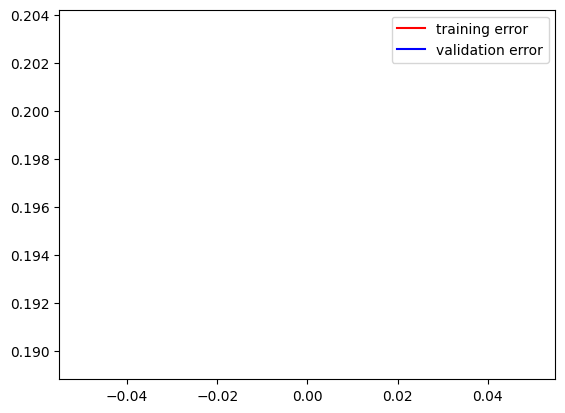

--------------------------------------------
Training = 5.0 %


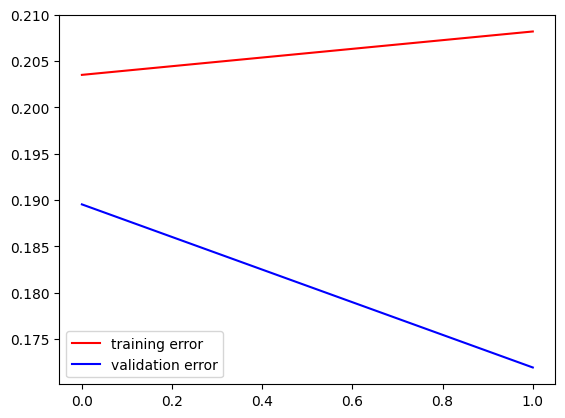

--------------------------------------------
Training = 10.0 %


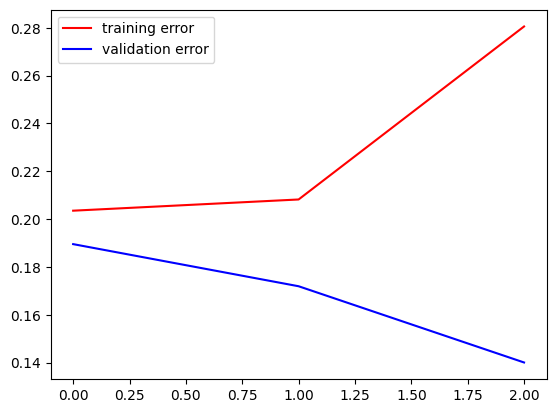

--------------------------------------------
Training = 15.0 %


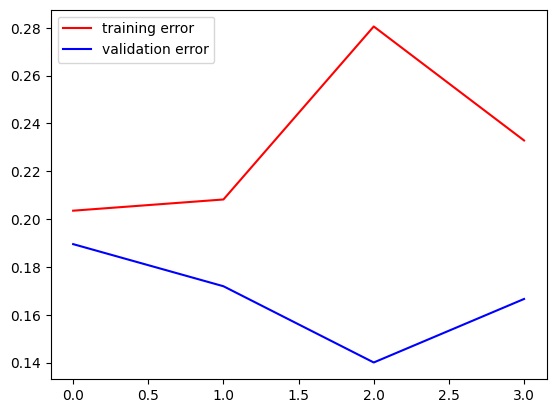

--------------------------------------------
Training = 20.0 %


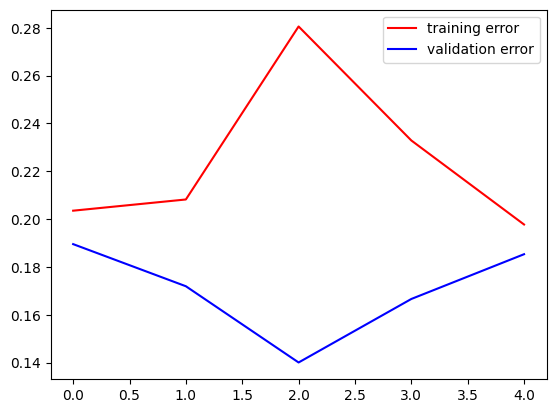

--------------------------------------------
Training = 25.0 %


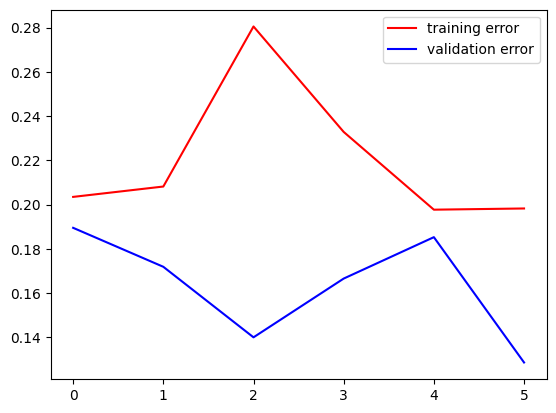

--------------------------------------------
Training = 30.0 %


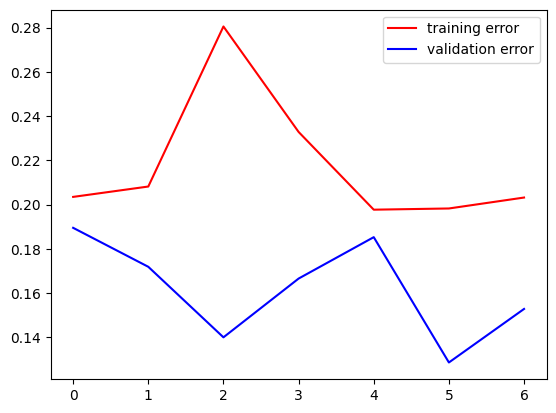

--------------------------------------------
Training = 35.0 %


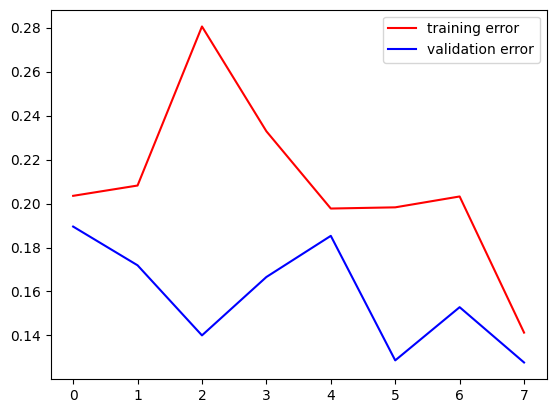

--------------------------------------------
Training = 40.0 %


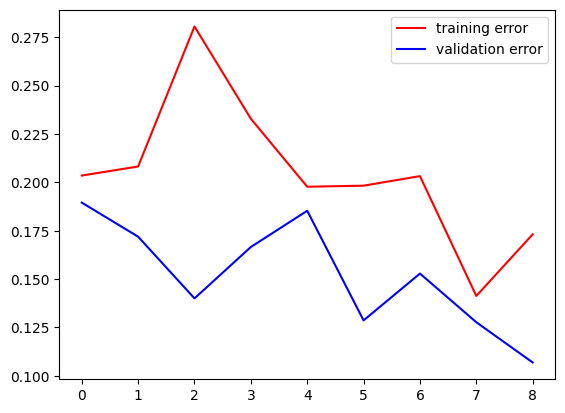

--------------------------------------------
Training = 45.0 %


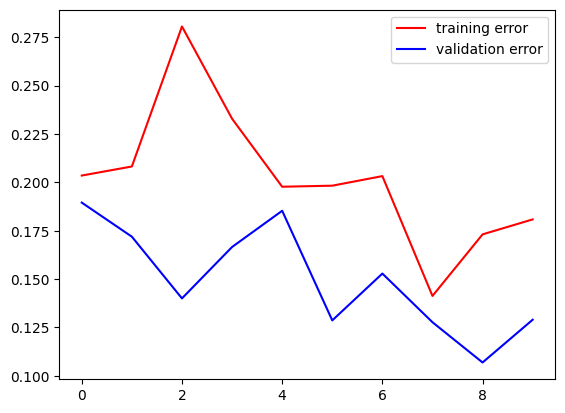

--------------------------------------------
Training = 50.0 %
epoch = 0
dim_clique = 20
training error = 0.17859894037246704
validation error = 0.09868927299976349
test error = 0.5133718252182007
--------------------------------------------
Early stop
--------------------------------------------


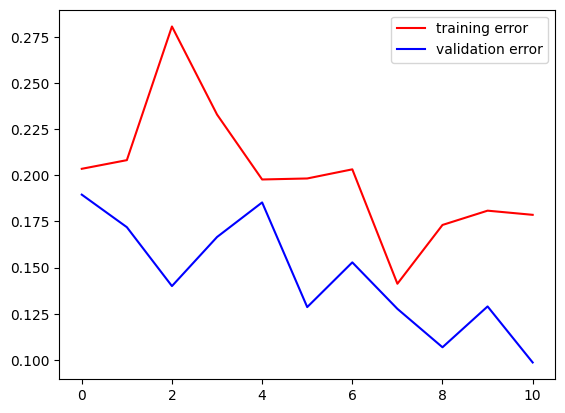

k/n = [5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0] % = [99.5, 95.5, 99.5, 99.0, 98.0, 97.0, 90.0]


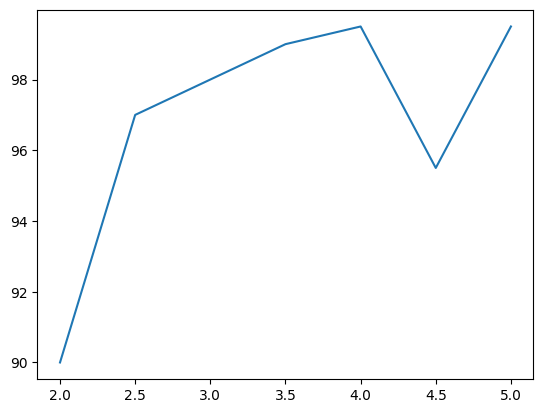

In [ ]:
epoch=10                  # number of epochs
max_steps=100             # maximum number of steps for each epoch
num_train=10              # dimension of the training set at each epoch
num_val=10               # dimension of the validation set
num_test=20              # dimension of the test set
dim_graph= 100            # number of nodes
start_dim_clique=50       # dimension of the clique to start with
jump=5                    # jump lengths for the first loop
save_step=5               # number of steps after which we check the early stopping criterion
stop = 19                     # clique size at which we stop
training_exit_error = 0.2    # training error below which we can stop early
validation_exit_error = 0.1  # validation error below which we can stop early
times=10

train_error=[]
val_error=[]

generalization=[]
k_over_sqrt_n=[]
for m in range(0,start_dim_clique - stop,jump):
  dim_clique = start_dim_clique - m
  test = GetClique(num_test,dim_graph,dim_clique,prob = 0.5)
  k_over_sqrt_n.append(1.0*dim_clique/math.sqrt(dim_graph))
  loss=1.0
  count=0

  for j in range(epoch):
    early_stop_counter=0
    min_validation_loss = np.inf
    train = GetClique(num_train,dim_graph,dim_clique, prob = 0.5)
    val = GetClique(num_val,dim_graph,dim_clique, prob = 0.5)
    for i in range(max_steps):
      output = model_g(train[0].to(device),train[1].to(device),train[2].to(device))
      loss=criterion(output.type(torch.float).to(device), torch.Tensor(train[3]).type(torch.long).to(device))

      # every "print_step" steps we save the error of the train and validation set
      if (i%save_step == 0):
        print('Training =',100.0*i/max_steps,'%')
        train_error.append(loss.item())
        check = model_g(val[0].to(device),val[1].to(device),val[2].to(device))   # checks the output on the validation set
        val_loss = criterion(check.to(device), torch.Tensor(val[3]).type(torch.long).to(device)).item()
        val_error.append(val_loss)

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_exit,min_validation_loss,early_stop_counter = EarlyStopper(np.array(val_error), early_stop_counter, min_validation_loss)
        if (val_error[count]<validation_exit_error or (early_exit and train_error[count]<training_exit_error)):
          count=count+1
          break

        count=count+1
        if (count > 30):
          # plot of test and validation error curves
          x_axis = np.arange(30)
          fig, ax = plt.subplots()
          ax.plot(x_axis, train_error[count-30:count], 'r', label='training error')
          ax.plot(x_axis, val_error[count-30:count], 'b', label='validation error')
          ax.legend()
          plt.show()
          print('--------------------------------------------')
        else:
          # plot of test and validation error curves
          x_axis = np.arange(count)
          fig, ax = plt.subplots()
          ax.plot(x_axis, train_error[:count], 'r', label='training error')
          ax.plot(x_axis, val_error[:count], 'b', label='validation error')
          ax.legend()
          plt.show()
          print('--------------------------------------------')

      loss.backward()
      optim.step()
      optim.zero_grad(set_to_none=True)


    # test error
    test_output = model_g(test[0].to(device),test[1].to(device),test[2].to(device))   # checks the output on the test set
    test_error = criterion(test_output.to(device), torch.Tensor(test[3]).type(torch.long).to(device))
    if (j%1 == 0):
      print('epoch =',j)
      print('dim_clique =',dim_clique)
      print('training error =', train_error[count-1])
      print('validation error =',val_error[count-1])
      print('test error =',test_error.item())
      print('--------------------------------------------')

    if (val_error[count-1]<validation_exit_error):
          print('Early stop')
          print('--------------------------------------------')
          break
  # plot of test and validation error curves
  x_axis = np.arange(count)
  fig, ax = plt.subplots()
  ax.plot(x_axis, train_error[:count], 'r', label='training error')
  ax.plot(x_axis, val_error[:count], 'b', label='validation error')
  ax.legend()
  plt.show()

  train_error=[]
  val_error=[]

  mean=0
  for j in range(times):
    data = GetClique(num_test,dim_graph,dim_clique)
    hard_output = torch.zeros([num_test,2])

    soft_output = model_g(data[0].to(device),data[1].to(device),data[2].to(device))
    for l in range(num_test):
      if (soft_output[l][0] > soft_output[l][1]):
        hard_output[l][0] = 1.0
      else: hard_output[l][1] = 1.0
    predicted_output = hard_output

    mean = mean + 100*(1-torch.sum(torch.square(torch.Tensor(data[3])-torch.transpose(predicted_output,1,0)[1])).item()/(1.0*num_test))

  mean = mean/times
  generalization.append(mean)

  print('k/n =', k_over_sqrt_n, '% =', generalization)
  print('==========================================')

plt.plot(k_over_sqrt_n,generalization)

Here we check the generalization error and we compute the transition at which the GNN starts to fail.

k = 85 ----> % = 100.0
k = 84 ----> % = 100.0
k = 83 ----> % = 100.0
k = 82 ----> % = 100.0
k = 81 ----> % = 100.0
k = 80 ----> % = 100.0
k = 79 ----> % = 100.0
k = 78 ----> % = 100.0
k = 77 ----> % = 100.0
k = 76 ----> % = 100.0
k = 75 ----> % = 100.0
k = 74 ----> % = 100.0
k = 73 ----> % = 100.0
k = 72 ----> % = 100.0
k = 71 ----> % = 100.0
k = 70 ----> % = 100.0
k = 69 ----> % = 100.0
k = 68 ----> % = 100.0
k = 67 ----> % = 100.0
k = 66 ----> % = 100.0
k = 65 ----> % = 100.0
k = 64 ----> % = 100.0
k = 63 ----> % = 100.0
k = 62 ----> % = 100.0
k = 61 ----> % = 100.0
k = 60 ----> % = 100.0
k = 59 ----> % = 100.0
k = 58 ----> % = 100.0
k = 57 ----> % = 100.0
k = 56 ----> % = 100.0
k = 55 ----> % = 100.0
k = 54 ----> % = 100.0
k = 53 ----> % = 100.0
k = 52 ----> % = 100.0
k = 51 ----> % = 99.66666666666667
k = 50 ----> % = 100.0
k = 49 ----> % = 100.0
k = 48 ----> % = 99.33333333333333
k = 47 ----> % = 99.33333333333333
k = 46 ----> % = 100.0
k = 45 ----> % = 99.66666666666667
k = 44 --

k = 3 ----> % = 47.333333333333336
k over sqrt(n) = [8.5, 8.4, 8.3, 8.2, 8.1, 8.0, 7.9, 7.8, 7.7, 7.6, 7.5, 7.4, 7.3, 7.2, 7.1, 7.0, 6.9, 6.8, 6.7, 6.6, 6.5, 6.4, 6.3, 6.2, 6.1, 6.0, 5.9, 5.8, 5.7, 5.6, 5.5, 5.4, 5.3, 5.2, 5.1, 5.0, 4.9, 4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2, 4.1, 4.0, 3.9, 3.8, 3.7, 3.6, 3.5, 3.4, 3.3, 3.2, 3.1, 3.0, 2.9, 2.8, 2.7, 2.6, 2.5, 2.4, 2.3, 2.2, 2.1, 2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3] % = [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.66666666666667, 100.0, 100.0, 99.33333333333333, 99.33333333333333, 100.0, 99.66666666666667, 98.33333333333333, 99.0, 98.66666666666667, 99.33333333333333, 98.33333333333333, 99.33333333333333, 98.66666666666667, 97.66666666666667, 96.66666666666667, 98.66666666666667, 96.333333333333

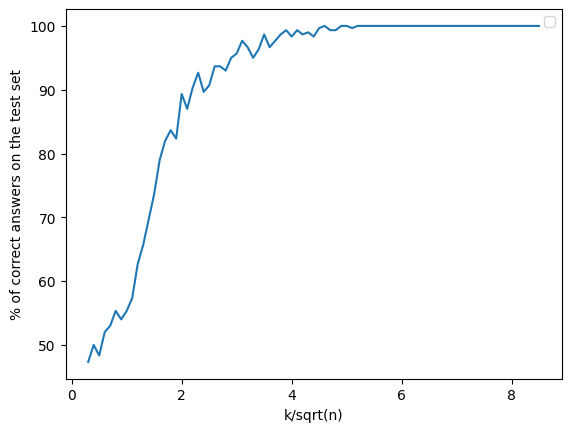

In [ ]:
start_dim_clique=85
stop = 2
times = 15

generalization_GNN = []
k_vs_sqrt_n_GNN = []

for m in range(0,start_dim_clique - stop,1):
  dim_clique = start_dim_clique - m
  k_vs_sqrt_n_GNN.append(1.0*dim_clique/math.sqrt(dim_graph))
  mean = 0

  for j in range(times):
    data = GetClique(num_test,dim_graph,dim_clique)
    hard_output = torch.zeros([num_test,2])

    soft_output = model_g(data[0].to(device),data[1].to(device),data[2].to(device))
    for l in range(num_test):
      if (soft_output[l][0] > soft_output[l][1]):
        hard_output[l][0] = 1.0
      else: hard_output[l][1] = 1.0
    predicted_output = hard_output

    mean = mean + 100*(1-torch.sum(torch.square(torch.Tensor(data[3])-torch.transpose(predicted_output,1,0)[1])).item()/(1.0*num_test))

  mean = mean/times
  generalization_GNN.append(mean)
  print('k =',dim_clique,'---->', '% =', mean)
  print('==========================================')
print('k over sqrt(n) =', list(k_vs_sqrt_n_GNN), '% =', list(generalization_GNN))
print('==========================================')

fig, ax = plt.subplots()
ax.plot(k_vs_sqrt_n_GNN,generalization_GNN)
plt.xlabel('k/sqrt(n)')
plt.ylabel('% of correct answers on the test set')
ax.legend()
plt.show()

# Performance Comparison

This is a comparison of the performance between the different models we tested on the problem

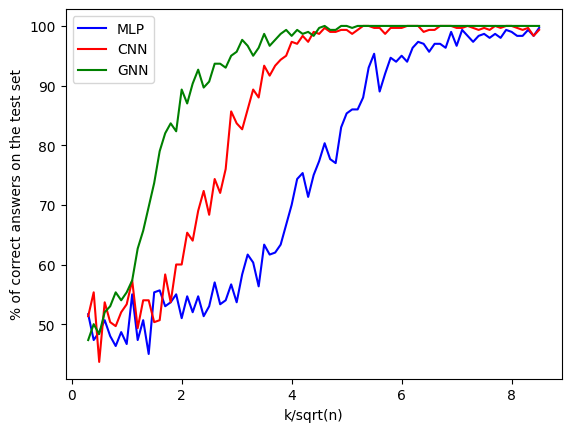

In [ ]:
fig, ax = plt.subplots()
ax.plot(k_vs_sqrt_n_MLP,generalization_MLP, 'b', label='MLP')
ax.plot(k_vs_sqrt_n_CNN,generalization_CNN, 'r', label='CNN')
ax.plot(k_vs_sqrt_n_GNN,generalization_GNN, 'g', label='GNN')
plt.xlabel('k/sqrt(n)')
plt.ylabel('% of correct answers on the test set')
ax.legend()
plt.show()